In [18]:
import json
from kafka import KafkaConsumer
from kafka import KafkaProducer
from elasticsearch import Elasticsearch
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [20]:
es = Elasticsearch()

In [21]:
stopwords_set = set(stopwords.words('english'))

In [22]:
emotions_to_parse = ["happy", "sad"]

data = []

for emotion in emotions_to_parse:
    tweets = es.search(index="fetched_tweets", body={"query": {"match": { "full_text": "#" + emotion }}, "size": 10000})

    for msg in tweets['hits']['hits']:
        full_msg_text = None

        # Skip retweeted tweets
        if "retweeted_status" in msg['_source']:
            continue

        data.append({
            'tweet_id': msg['_id'],
            'full_text': msg['_source']['full_text'],
            'emotion': emotion
        })

In [23]:
def cleanup_tweet(text):
    tknzr = TweetTokenizer()
    
    text = text.lower()
    
    tokens = tknzr.tokenize(text)
    clean_tokens = []
    
    for token in tokens:
        # Skip hashtags
        if token[0] == "#":
            continue
            
        # Some words end with ":" or "!" are treated as non words. I'd like to include those actually.
        # An example is: "very happy!". Basically, it's a valid ngram, but sign at the end of word
        # results in it being treated as invalid word
        token = re.sub(r'[!:,]$', '', token)
        
        # Doesnt start with letter? Not a word, IMO
        if not re.match("^[a-zA-Z]+", token):
            continue
            
        # Link? Skip it!
        if re.match("^http[s]:\/\/", token):
            continue
            
        # Skip stopwords
        if token in stopwords_set:
            continue

        clean_tokens.append(token)
        
    return " ".join(clean_tokens)

In [24]:
text = 'Happy kid ❤\n#happy https://t.co/6F3SnnYA52'

cleanup_tweet(text)

'happy kid'

In [25]:
data_df = pd.DataFrame(data)
data_df.set_index('tweet_id', inplace=True)
data_df['clean_text'] = data_df['full_text'].apply(cleanup_tweet)

In [26]:
data_df.head(5)

emotion  \
tweet_id                      
1136544883064229888   happy   
1136615042869338120   happy   
1136466744850038784   happy   
1136438986677923841   happy   
1136599233392332801   happy   

                                                             full_text  \
tweet_id                                                                 
1136544883064229888        Happy kid ❤\n#happy https://t.co/6F3SnnYA52   
1136615042869338120  Happy Thursday.  #nycsubway #meandyou #happy h...   
1136466744850038784    @maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑   
1136438986677923841  Happy New Year 2018 Quotes: #Happy New Year 20...   
1136599233392332801  Without you, I’m not happy\nbut I hope you’re ...   

                                                            clean_text  
tweet_id                                                                
1136544883064229888                                          happy kid  
1136615042869338120                                     happy thursday  
1136466744850038784                        looks comfy happy kev's dad  
1136438986677923841  happy new year quotes new year images new year...  
1136599233392332801  without happy hope happy watch far away withou...

In [27]:
data_df[data_df.emotion == "sad"].head(5)

emotion  \
tweet_id                      
1136151013851664384     sad   
1135808735383699458     sad   
1136318200218624002     sad   
1136100282830663681     sad   
1135457328218554368     sad   

                                                             full_text  \
tweet_id                                                                 
1136151013851664384              You sad? Aww that's sad #sadness #sad   
1135808735383699458  I’m sad so ennala comments panna mudiyala foll...   
1136318200218624002  @marty_lederman @gtconway3d #Sad. Very sad ind...   
1136100282830663681                  I lost my dog and am sad #sad dog   
1135457328218554368  @maggieNYT Sad that this is our diplomatic lea...   

                                                           clean_text  
tweet_id                                                               
1136151013851664384                                sad aww that's sad  
1135808735383699458  sad ennala comments panna mudiyala followers sry  
1136318200218624002                                        sad indeed  
1136100282830663681                                  lost dog sad dog  
1135457328218554368                               sad diplomatic lead

In [28]:
data_df.sample(frac=1).head(10)

emotion  \
tweet_id                      
1135576478173847553     sad   
1136633862652661760   happy   
1135950026482573313     sad   
1135578064061128704     sad   
1135516032880144384     sad   
1135729631053697025     sad   
1136608762213650432   happy   
1136607965916672000   happy   
1136213326390841345     sad   
1135684194527514625     sad   

                                                             full_text  \
tweet_id                                                                 
1135576478173847553  Goppers are hooked on the “kool-aid”. I fear t...   
1136633862652661760  Striiing lights!\n.\n #love #fashion #photooft...   
1135950026482573313  ♡♫ Tags: #gracevanderwaal #darknesskeepschasin...   
1135578064061128704  @realDonaldTrump @ATT @CNN For someone that so...   
1135516032880144384  Very unhappy, woke up at 4:50am still with tea...   
1135729631053697025  @realDonaldTrump #TrumpsAnInternationalDisgrac...   
1136608762213650432  Teamwork can make a dream work \n\n.\n.\n.\n.\...   
1136607965916672000  #Love &amp; #coffee!  What better #weekly #jou...   
1136213326390841345  @JoeNBC And this buffoon will be in #Normandy ...   
1135684194527514625  The once great UK now a shadow of its former s...   

                                                            clean_text  
tweet_id                                                                
1135576478173847553          goppers hooked kool-aid fear lost forever  
1136633862652661760                                    striiing lights  
1135950026482573313                                               tags  
1135578064061128704  someone sold businessman apparently understand...  
1135516032880144384                   unhappy woke still tears flowing  
1135729631053697025                               everyone loves obama  
1136608762213650432                           teamwork make dream work  
1136607965916672000                            better combination life  
1136213326390841345  buffoon mark anniversary even acts presidentia...  
1135684194527514625                        great uk shadow former self

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [30]:
X = data_df.clean_text
y = data_df.emotion

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [32]:
X_train.shape

(3200,)

In [33]:
X_test.shape

(1067,)

In [34]:
model.fit(X_train, y_train)

NameError: name 'model' is not defined

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['happy', 'sad'], yticklabels=['happy', 'sad'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
model.predict([cleanup_tweet("Work hard at your dreams. \"Nothing will work unless you do.\" Maya Angelou #positive ")])

In [ ]:
ord("😁")

# Do everything manually

In [36]:
vectorizer = TfidfVectorizer()

In [37]:
X = vectorizer.fit_transform(data_df.clean_text)
y = data_df.emotion

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [38]:
X_train.shape

(3200, 8971)

In [39]:
X_test.shape

(1067, 8971)

In [40]:
y_train.value_counts()

sad      2198
happy    1002
Name: emotion, dtype: int64

In [41]:
from sklearn import svm

In [42]:
model = svm.SVC()

In [43]:
model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [44]:
y_pred = model.predict(X_test)

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
accuracy_score(y_test, y_pred)

0.6944704779756327

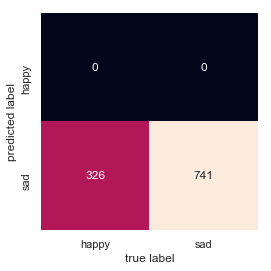

In [47]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['happy', 'sad'], yticklabels=['happy', 'sad'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [48]:
y_pred[y_pred == 'happy']

array([], dtype=object)

In [49]:
confusion_matrix(y_test, y_pred)

array([[  0, 326],
       [  0, 741]])

For whatever reason, SVC classifies everything as "sad"

In [50]:
from sklearn.naive_bayes import GaussianNB

# Try Naive Bayes
model = GaussianNB()
model.fit(X_train.toarray(), y_train)

GaussianNB(priors=None)

In [51]:
y_pred = model.predict(X_test.toarray())

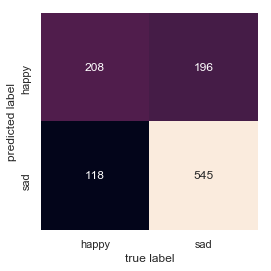

In [52]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['happy', 'sad'], yticklabels=['happy', 'sad'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [53]:
accuracy_score(y_test, y_pred)

0.7057169634489222

Let's try with 100 params for TF-IDF vectorizer ...

In [54]:
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(data_df.clean_text)
y = data_df.emotion

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [55]:
model = svm.SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.6888472352389878

In [56]:
model = GaussianNB()
model.fit(X_train.toarray(), y_train)

y_pred = model.predict(X_test.toarray())

accuracy_score(y_test, y_pred)

0.6241799437675727

Ok so it seems that SVC is getting better than Naive Bayes ... Let's try Multinomial Naive Bayes

In [57]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.7197750702905342

Seems like MultinomialNB is giving best results so far. Let's see how accuracy changes depending on number of features for vectorizer

In [58]:
from sklearn.metrics import f1_score

In [59]:
def get_accuracy_score(num_features):
    vectorizer = TfidfVectorizer(max_features=num_features)
    X = vectorizer.fit_transform(data_df.clean_text)
    y = data_df.emotion

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    #model = MultinomialNB()
    #model = svm.SVC()
    model = GaussianNB()
#     model.fit(X_train, y_train)
    model.fit(X_train.toarray(), y_train)

    y_pred = model.predict(X_test.toarray())

    return accuracy_score(y_test, y_pred), model

In [60]:
accuracies = []

for i in range(10, 5000):
    print("Num features: " + str(i))
    
    #accuracy, f1 = get_accuracy_score(i)
    
    accuracy = get_accuracy_score(i)
    
    #accuracies.append([i, accuracy, f1])
    
    accuracies.append([i, accuracy[0]])

accuracies = np.array(accuracies)

Num features: 10
Num features: 11
Num features: 12
Num features: 13
Num features: 14
Num features: 15
Num features: 16
Num features: 17
Num features: 18
Num features: 19
Num features: 20
Num features: 21
Num features: 22
Num features: 23
Num features: 24
Num features: 25
Num features: 26
Num features: 27
Num features: 28
Num features: 29
Num features: 30
Num features: 31
Num features: 32
Num features: 33
Num features: 34
Num features: 35
Num features: 36
Num features: 37
Num features: 38
Num features: 39
Num features: 40
Num features: 41
Num features: 42
Num features: 43
Num features: 44
Num features: 45
Num features: 46
Num features: 47
Num features: 48
Num features: 49
Num features: 50
Num features: 51
Num features: 52
Num features: 53
Num features: 54
Num features: 55
Num features: 56
Num features: 57
Num features: 58
Num features: 59
Num features: 60
Num features: 61
Num features: 62
Num features: 63
Num features: 64
Num features: 65
Num features: 66
Num features: 67
Num features: 

Num features: 472
Num features: 473
Num features: 474
Num features: 475
Num features: 476
Num features: 477
Num features: 478
Num features: 479
Num features: 480
Num features: 481
Num features: 482
Num features: 483
Num features: 484
Num features: 485
Num features: 486
Num features: 487
Num features: 488
Num features: 489
Num features: 490
Num features: 491
Num features: 492
Num features: 493
Num features: 494
Num features: 495
Num features: 496
Num features: 497
Num features: 498
Num features: 499
Num features: 500
Num features: 501
Num features: 502
Num features: 503
Num features: 504
Num features: 505
Num features: 506
Num features: 507
Num features: 508
Num features: 509
Num features: 510
Num features: 511
Num features: 512
Num features: 513
Num features: 514
Num features: 515
Num features: 516
Num features: 517
Num features: 518
Num features: 519
Num features: 520
Num features: 521
Num features: 522
Num features: 523
Num features: 524
Num features: 525
Num features: 526
Num featur

KeyboardInterrupt: 

In [ ]:
accuracies = np.array(accuracies)

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
plt.plot(accuracies[:, 0], accuracies[:, 1])
plt.xlabel('Number of features')
plt.ylabel('Accuracy');

In [ ]:
def test_function():
    return 1, 2

In [ ]:
a,b = test_function()

In [ ]:
a

In [ ]:
b

In [ ]:
model = get_accuracy_score(3000)

In [61]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(data_df.clean_text)
y = data_df.emotion

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = svm.SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [62]:
X_train.shape

(3200, 1000)

In [63]:
X_test.shape

(1067, 1000)

In [64]:
accuracy_score(y_test, y_pred)

0.6944704779756327

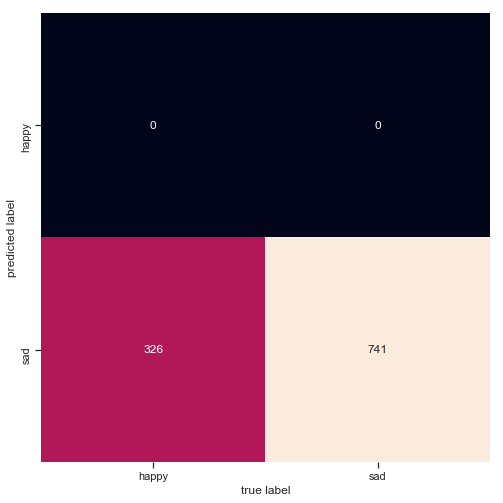

In [65]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['happy', 'sad'], yticklabels=['happy', 'sad'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [66]:
test_samples = data_df.sample(frac=1).head(10)

In [67]:
def get_emotion(text):
    vector = vectorizer.transform([text])
    
    return model.predict(vector)[0]

In [68]:
test_samples['predicted'] = test_samples.clean_text.apply(get_emotion)

In [69]:
test_samples.sample(frac=1)[['full_text', 'clean_text', 'emotion', 'predicted']]

full_text  \
tweet_id                                                                 
1136540774370140160  Happy!!! #eid #eidmubarak #idulfitri #lebaran ...   
1136129756439597056  @DLoesch Well, technically I would have accept...   
1136356086188036096  Sad nibba hours\n#sad https://t.co/iD9Uogwt6t ...   
1136510444586328066  What is that puts a smile on your face? #happy...   
1135885319163846657  @Shaydakisses Just after attention , trying to...   
1135953219132317697  @EvertonBlues_ The highlight of Everton's seas...   
1136422681069465600  Diversity is the key to understanding the enti...   
1136317077386608642  🤔 If you don't know what's missing you are lik...   
1136117340196622336  @SamesCarolyn @osullivanauthor Really?  10,000...   
1136538540827959296  When a leader has VISION the followers DREAM B...   

                                                            clean_text  \
tweet_id                                                                 
1136540774370140160                                              happy   
1136129756439597056  well technically would accepted pride teacher ...   
1136356086188036096                                    sad nibba hours   
1136510444586328066                                    puts smile face   
1135885319163846657                  attention trying boost popularity   
1135953219132317697  highlight everton's season car going around pl...   
1136422681069465600  diversity key understanding entire story thank...   
1136317077386608642            know what's missing likely part problem   
1136117340196622336  really documented lies think sides even guess ...   
1136538540827959296                  leader vision followers dream big   

                    emotion predicted  
tweet_id                               
1136540774370140160   happy       sad  
1136129756439597056     sad       sad  
1136356086188036096     sad       sad  
1136510444586328066   happy       sad  
1135885319163846657     sad       sad  
1135953219132317697     sad       sad  
1136422681069465600     sad       sad  
1136317077386608642     sad       sad  
1136117340196622336     sad       sad  
1136538540827959296   happy       sad

In [70]:
test_samples[test_samples['predicted'] == 'happy']

Empty DataFrame
Columns: [emotion, full_text, clean_text, predicted]
Index: []

In [71]:
data_df.clean_text

tweet_id
1136544883064229888                                            happy kid
1136615042869338120                                       happy thursday
1136466744850038784                          looks comfy happy kev's dad
1136438986677923841    happy new year quotes new year images new year...
1136599233392332801    without happy hope happy watch far away withou...
1136575521205055490                     happy wife happy life life thank
1136439712498016256                                 happy long i'm happy
1136531662911787008                                 happy holidays ibiza
1136540774370140160                                                happy
1136436068067287041                                   tf happy cancelled
1136569288121339904                           happy thursday angler fish
1136591452664975360    quick happy hippo sketch happy thursday santa ...
1136528758196727810              happy birthday brother great year ahead
1136513623730393088                       

In [72]:
from wordcloud import WordCloud

In [73]:
text = " ".join(clean_text for clean_text in data_df[data_df['emotion'] == 'sad'].clean_text)

In [74]:
wordcloud = WordCloud().generate(text)

(-0.5, 399.5, 199.5, -0.5)

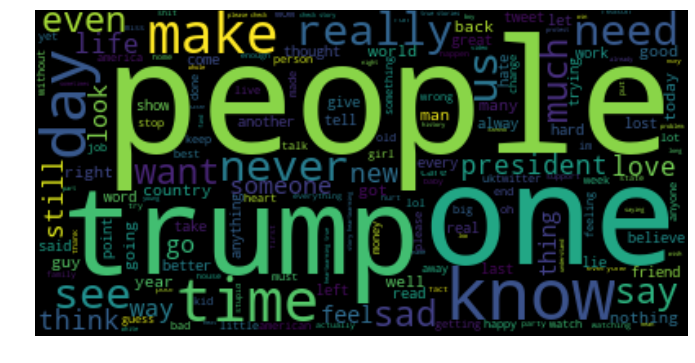

In [75]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

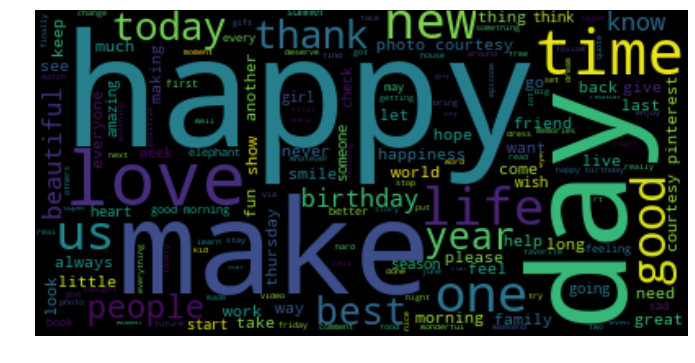

In [76]:
text = " ".join(clean_text for clean_text in data_df[data_df['emotion'] == 'happy'].clean_text)
wordcloud = WordCloud().generate(text)
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [77]:
# Do some explorations on text data
# Basically, we want to create a dataframe with occurences for each word, etc

In [78]:
tokens_df = pd.DataFrame(columns=['tweet_id', 'token', 'emotion', 'clean_text', 'full_text'])

In [79]:
tokens_list = []

for tweet_id, clean_text in data_df.clean_text.iteritems():
    for token in clean_text.split():
        print("\n\n")
        
        print("Tweet ID: " + tweet_id)
        print(data_df.loc[tweet_id].emotion)
        
#         tokens_list.append([
#             tweet_id, 
#             token, 
#             data_df.loc[tweet_id].emotion
#         ])
    




Tweet ID: 1136544883064229888
happy



Tweet ID: 1136544883064229888
happy



Tweet ID: 1136615042869338120
happy



Tweet ID: 1136615042869338120
happy



Tweet ID: 1136466744850038784
happy



Tweet ID: 1136466744850038784
happy



Tweet ID: 1136466744850038784
happy



Tweet ID: 1136466744850038784
happy



Tweet ID: 1136466744850038784
happy



Tweet ID: 1136438986677923841
happy



Tweet ID: 1136438986677923841
happy



Tweet ID: 1136438986677923841
happy



Tweet ID: 1136438986677923841
happy



Tweet ID: 1136438986677923841
happy



Tweet ID: 1136438986677923841
happy



Tweet ID: 1136438986677923841
happy



Tweet ID: 1136438986677923841
happy



Tweet ID: 1136438986677923841
happy



Tweet ID: 1136438986677923841
happy



Tweet ID: 1136438986677923841
happy



Tweet ID: 1136438986677923841
happy



Tweet ID: 1136599233392332801
happy



Tweet ID: 1136599233392332801
happy



Tweet ID: 1136599233392332801
happy



Tweet ID: 1136599233392332801
happy



Tweet ID: 113659923339

happy



Tweet ID: 1136570661634097152
happy



Tweet ID: 1136570661634097152
happy



Tweet ID: 1136570661634097152
happy



Tweet ID: 1136461818208051200
happy



Tweet ID: 1136461818208051200
happy



Tweet ID: 1136465220304494593
happy



Tweet ID: 1136465220304494593
happy



Tweet ID: 1136465220304494593
happy



Tweet ID: 1136465220304494593
happy



Tweet ID: 1136465220304494593
happy



Tweet ID: 1136396141652787200
tweet_id
1136396141652787200    happy
1136396141652787200      sad
Name: emotion, dtype: object



Tweet ID: 1136396141652787200
tweet_id
1136396141652787200    happy
1136396141652787200      sad
Name: emotion, dtype: object



Tweet ID: 1136396141652787200
tweet_id
1136396141652787200    happy
1136396141652787200      sad
Name: emotion, dtype: object



Tweet ID: 1136396141652787200
tweet_id
1136396141652787200    happy
1136396141652787200      sad
Name: emotion, dtype: object



Tweet ID: 1136560123382456320
happy



Tweet ID: 1136560123382456320
happy



Tweet I

happy



Tweet ID: 1136510302688702464
happy



Tweet ID: 1136510302688702464
happy



Tweet ID: 1136510302688702464
happy



Tweet ID: 1136607041487872000
happy



Tweet ID: 1136607041487872000
happy



Tweet ID: 1136607041487872000
happy



Tweet ID: 1136607041487872000
happy



Tweet ID: 1136607041487872000
happy



Tweet ID: 1136607041487872000
happy



Tweet ID: 1136607041487872000
happy



Tweet ID: 1136607041487872000
happy



Tweet ID: 1136555023339380736
happy



Tweet ID: 1136555023339380736
happy



Tweet ID: 1136555023339380736
happy



Tweet ID: 1136555023339380736
happy



Tweet ID: 1136555023339380736
happy



Tweet ID: 1136555023339380736
happy



Tweet ID: 1136555023339380736
happy



Tweet ID: 1136555023339380736
happy



Tweet ID: 1136555023339380736
happy



Tweet ID: 1136555023339380736
happy



Tweet ID: 1136555023339380736
happy



Tweet ID: 1136555023339380736
happy



Tweet ID: 1136555023339380736
happy



Tweet ID: 1136555023339380736
happy



Tweet ID: 113655

happy



Tweet ID: 1136577981856460801
happy



Tweet ID: 1136577981856460801
happy



Tweet ID: 1136577981856460801
happy



Tweet ID: 1136636426303311873
happy



Tweet ID: 1136636426303311873
happy



Tweet ID: 1136636426303311873
happy



Tweet ID: 1136636426303311873
happy



Tweet ID: 1136636426303311873
happy



Tweet ID: 1136636426303311873
happy



Tweet ID: 1136636426303311873
happy



Tweet ID: 1136633164741451776
happy



Tweet ID: 1136633164741451776
happy



Tweet ID: 1136633164741451776
happy



Tweet ID: 1136631757363531776
happy



Tweet ID: 1136631621451493378
happy



Tweet ID: 1136631621451493378
happy



Tweet ID: 1136631621451493378
happy



Tweet ID: 1136631621451493378
happy



Tweet ID: 1136631621451493378
happy



Tweet ID: 1136628900438523909
happy



Tweet ID: 1136628900438523909
happy



Tweet ID: 1136628900438523909
happy



Tweet ID: 1136628900438523909
happy



Tweet ID: 1136628900438523909
happy



Tweet ID: 1136529027085324289
happy



Tweet ID: 113652




Tweet ID: 1136462012119179264
happy



Tweet ID: 1136462012119179264
happy



Tweet ID: 1136459388389011456
happy



Tweet ID: 1136459388389011456
happy



Tweet ID: 1136459388389011456
happy



Tweet ID: 1136459388389011456
happy



Tweet ID: 1136459388389011456
happy



Tweet ID: 1136459388389011456
happy



Tweet ID: 1136457207506231297
happy



Tweet ID: 1136457207506231297
happy



Tweet ID: 1136457207506231297
happy



Tweet ID: 1136457207506231297
happy



Tweet ID: 1136457207506231297
happy



Tweet ID: 1136442402175168513
happy



Tweet ID: 1136442402175168513
happy



Tweet ID: 1136465879892484097
happy



Tweet ID: 1136465879892484097
happy



Tweet ID: 1136465879892484097
happy



Tweet ID: 1136465879892484097
happy



Tweet ID: 1136465879892484097
happy



Tweet ID: 1136465879892484097
happy



Tweet ID: 1136463821764222976
happy



Tweet ID: 1136463821764222976
happy



Tweet ID: 1136463821764222976
happy



Tweet ID: 1136463821764222976
happy



Tweet ID: 113646382176

happy



Tweet ID: 1136587846876389377
happy



Tweet ID: 1136587846876389377
happy



Tweet ID: 1136587846876389377
happy



Tweet ID: 1136567386058964992
happy



Tweet ID: 1136567386058964992
happy



Tweet ID: 1136567386058964992
happy



Tweet ID: 1136565987237605376
happy



Tweet ID: 1136565987237605376
happy



Tweet ID: 1136565987237605376
happy



Tweet ID: 1136565987237605376
happy



Tweet ID: 1136565987237605376
happy



Tweet ID: 1136482952681000961
happy



Tweet ID: 1136482952681000961
happy



Tweet ID: 1136482952681000961
happy



Tweet ID: 1136482952681000961
happy



Tweet ID: 1136482952681000961
happy



Tweet ID: 1136448406564560899
happy



Tweet ID: 1136448406564560899
happy



Tweet ID: 1136448406564560899
happy



Tweet ID: 1136448406564560899
happy



Tweet ID: 1136448406564560899
happy



Tweet ID: 1136448406564560899
happy



Tweet ID: 1136448406564560899
happy



Tweet ID: 1136448406564560899
happy



Tweet ID: 1136448406564560899
happy



Tweet ID: 113646


Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136470650586091520
happy



Tweet ID: 1136635492945006593
happy



Tweet ID: 1136635492945006593
happy



Tweet ID: 11366354929450


Tweet ID: 1136589032966766592
happy



Tweet ID: 1136589032966766592
happy



Tweet ID: 1136589032966766592
happy



Tweet ID: 1136551360479006722
happy



Tweet ID: 1136551360479006722
happy



Tweet ID: 1136551360479006722
happy



Tweet ID: 1136540486959849472
happy



Tweet ID: 1136564490533838848
happy



Tweet ID: 1136564490533838848
happy



Tweet ID: 1136564490533838848
happy



Tweet ID: 1136564490533838848
happy



Tweet ID: 1136564490533838848
happy



Tweet ID: 1136564490533838848
happy



Tweet ID: 1136569255770632194
happy



Tweet ID: 1136569255770632194
happy



Tweet ID: 1136569255770632194
happy



Tweet ID: 1136569255770632194
happy



Tweet ID: 1136569255770632194
happy



Tweet ID: 1136569255770632194
happy



Tweet ID: 1136569032759435264
happy



Tweet ID: 1136569032759435264
happy



Tweet ID: 1136569032759435264
happy



Tweet ID: 1136569032759435264
happy



Tweet ID: 1136569032759435264
happy



Tweet ID: 1136555064775061504
happy



Tweet ID: 11365550647750

happy



Tweet ID: 1136641065270878209
happy



Tweet ID: 1136641065270878209
happy



Tweet ID: 1136641065270878209
happy



Tweet ID: 1136641065270878209
happy



Tweet ID: 1136641065270878209
happy



Tweet ID: 1136641065270878209
happy



Tweet ID: 1136641065270878209
happy



Tweet ID: 1136635161951346688
happy



Tweet ID: 1136635161951346688
happy



Tweet ID: 1136633156558303233
happy



Tweet ID: 1136633156558303233
happy



Tweet ID: 1136633156558303233
happy



Tweet ID: 1136633156558303233
happy



Tweet ID: 1136540445457244160
happy



Tweet ID: 1136539074616070144
happy



Tweet ID: 1136539074616070144
happy



Tweet ID: 1136539074616070144
happy



Tweet ID: 1136539074616070144
happy



Tweet ID: 1136539074616070144
happy



Tweet ID: 1136539074616070144
happy



Tweet ID: 1136539074616070144
happy



Tweet ID: 1136539074616070144
happy



Tweet ID: 1136539074616070144
happy



Tweet ID: 1136539074616070144
happy



Tweet ID: 1136539074616070144
happy



Tweet ID: 113653

happy



Tweet ID: 1136531162191605760
happy



Tweet ID: 1136531162191605760
happy



Tweet ID: 1136531162191605760
happy



Tweet ID: 1136526999684616193
happy



Tweet ID: 1136526999684616193
happy



Tweet ID: 1136526999684616193
happy



Tweet ID: 1136537713824423936
happy



Tweet ID: 1136537713824423936
happy



Tweet ID: 1136537713824423936
happy



Tweet ID: 1136537713824423936
happy



Tweet ID: 1136537713824423936
happy



Tweet ID: 1136537713824423936
happy



Tweet ID: 1136537713824423936
happy



Tweet ID: 1136536536336482304
happy



Tweet ID: 1136536536336482304
happy



Tweet ID: 1136536536336482304
happy



Tweet ID: 1136521035807961088
happy



Tweet ID: 1136521035807961088
happy



Tweet ID: 1136486498390487045
happy



Tweet ID: 1136486498390487045
happy



Tweet ID: 1136505846219857922
happy



Tweet ID: 1136505846219857922
happy



Tweet ID: 1136505846219857922
happy



Tweet ID: 1136505846219857922
happy



Tweet ID: 1136505846219857922
happy



Tweet ID: 113661

happy



Tweet ID: 1136601562011373568
happy



Tweet ID: 1136601562011373568
happy



Tweet ID: 1136601562011373568
happy



Tweet ID: 1136601562011373568
happy



Tweet ID: 1136581778624393216
happy



Tweet ID: 1136588066120970240
happy



Tweet ID: 1136559877059436545
happy



Tweet ID: 1136559877059436545
happy



Tweet ID: 1136559877059436545
happy



Tweet ID: 1136559877059436545
happy



Tweet ID: 1136559877059436545
happy



Tweet ID: 1136548756688691200
happy



Tweet ID: 1136548756688691200
happy



Tweet ID: 1136547110860419072
happy



Tweet ID: 1136547110860419072
happy



Tweet ID: 1136543779790438400
happy



Tweet ID: 1136543779790438400
happy



Tweet ID: 1136543779790438400
happy



Tweet ID: 1136543779790438400
happy



Tweet ID: 1136543779790438400
happy



Tweet ID: 1136543779790438400
happy



Tweet ID: 1136543779790438400
happy



Tweet ID: 1136573345510465537
happy



Tweet ID: 1136573345510465537
happy



Tweet ID: 1136573345510465537
happy



Tweet ID: 113657

happy



Tweet ID: 1136496010207870981
happy



Tweet ID: 1136496010207870981
happy



Tweet ID: 1136518957911945216
happy



Tweet ID: 1136518957911945216
happy



Tweet ID: 1136518957911945216
happy



Tweet ID: 1136615242421735424
happy



Tweet ID: 1136615242421735424
happy



Tweet ID: 1136615242421735424
happy



Tweet ID: 1136615242421735424
happy



Tweet ID: 1136615242421735424
happy



Tweet ID: 1136615242421735424
happy



Tweet ID: 1136615242421735424
happy



Tweet ID: 1136615242421735424
happy



Tweet ID: 1136615242421735424
happy



Tweet ID: 1136615242421735424
happy



Tweet ID: 1136615242421735424
happy



Tweet ID: 1136615242421735424
happy



Tweet ID: 1136622035361325057
happy



Tweet ID: 1136622035361325057
happy



Tweet ID: 1136622035361325057
happy



Tweet ID: 1136622035361325057
happy



Tweet ID: 1136622035361325057
happy



Tweet ID: 1136622035361325057
happy



Tweet ID: 1136622035361325057
happy



Tweet ID: 1136622035361325057
happy



Tweet ID: 113662

happy



Tweet ID: 1136615243495424001
happy



Tweet ID: 1136615243495424001
happy



Tweet ID: 1136615243495424001
happy



Tweet ID: 1136615243495424001
happy



Tweet ID: 1136615243495424001
happy



Tweet ID: 1136615243495424001
happy



Tweet ID: 1136621516496523270
happy



Tweet ID: 1136621516496523270
happy



Tweet ID: 1136618940933791748
happy



Tweet ID: 1136618940933791748
happy



Tweet ID: 1136618940933791748
happy



Tweet ID: 1136606432718143488
happy



Tweet ID: 1136606432718143488
happy



Tweet ID: 1136606432718143488
happy



Tweet ID: 1136606432718143488
happy



Tweet ID: 1136596769519886336
happy



Tweet ID: 1136610736984084480
happy



Tweet ID: 1136610736984084480
happy



Tweet ID: 1136610736984084480
happy



Tweet ID: 1136610736984084480
happy



Tweet ID: 1136610736984084480
happy



Tweet ID: 1136598782672605184
happy



Tweet ID: 1136598782672605184
happy



Tweet ID: 1136598394518925312
happy



Tweet ID: 1136598394518925312
happy



Tweet ID: 113659

happy



Tweet ID: 1136561049748922368
happy



Tweet ID: 1136561049748922368
happy



Tweet ID: 1136560061457805312
happy



Tweet ID: 1136560061457805312
happy



Tweet ID: 1136560061457805312
happy



Tweet ID: 1136560061457805312
happy



Tweet ID: 1136560061457805312
happy



Tweet ID: 1136560061457805312
happy



Tweet ID: 1136560061457805312
happy



Tweet ID: 1136560061457805312
happy



Tweet ID: 1136551825644183552
happy



Tweet ID: 1136551825644183552
happy



Tweet ID: 1136551825644183552
happy



Tweet ID: 1136551825644183552
happy



Tweet ID: 1136551825644183552
happy



Tweet ID: 1136551825644183552
happy



Tweet ID: 1136551825644183552
happy



Tweet ID: 1136551825644183552
happy



Tweet ID: 1136551825644183552
happy



Tweet ID: 1136572199173853185
happy



Tweet ID: 1136572199173853185
happy



Tweet ID: 1136572199173853185
happy



Tweet ID: 1136572199173853185
happy



Tweet ID: 1136572199173853185
happy



Tweet ID: 1136556018622767104
happy



Tweet ID: 113655

happy



Tweet ID: 1136556270209490944
happy



Tweet ID: 1136556270209490944
happy



Tweet ID: 1136556270209490944
happy



Tweet ID: 1136556270209490944
happy



Tweet ID: 1136556270209490944
happy



Tweet ID: 1136556270209490944
happy



Tweet ID: 1136556270209490944
happy



Tweet ID: 1136545845514506240
happy



Tweet ID: 1136545845514506240
happy



Tweet ID: 1136545845514506240
happy



Tweet ID: 1136545845514506240
happy



Tweet ID: 1136545845514506240
happy



Tweet ID: 1136545845514506240
happy



Tweet ID: 1136545845514506240
happy



Tweet ID: 1136545845514506240
happy



Tweet ID: 1136566421574606848
happy



Tweet ID: 1136566421574606848
happy



Tweet ID: 1136566421574606848
happy



Tweet ID: 1136566421574606848
happy



Tweet ID: 1136566421574606848
happy



Tweet ID: 1136566421574606848
happy



Tweet ID: 1136448753710305280
happy



Tweet ID: 1136448753710305280
happy



Tweet ID: 1136448753710305280
happy



Tweet ID: 1136448753710305280
happy



Tweet ID: 113644

happy



Tweet ID: 1136625800374116352
happy



Tweet ID: 1136625800374116352
happy



Tweet ID: 1136625800374116352
happy



Tweet ID: 1136625800374116352
happy



Tweet ID: 1136625800374116352
happy



Tweet ID: 1136625800374116352
happy



Tweet ID: 1136609203752251393
happy



Tweet ID: 1136609203752251393
happy



Tweet ID: 1136609203752251393
happy



Tweet ID: 1136609203752251393
happy



Tweet ID: 1136609203752251393
happy



Tweet ID: 1136609091013550080
happy



Tweet ID: 1136609091013550080
happy



Tweet ID: 1136609091013550080
happy



Tweet ID: 1136609091013550080
happy



Tweet ID: 1136609091013550080
happy



Tweet ID: 1136609091013550080
happy



Tweet ID: 1136609091013550080
happy



Tweet ID: 1136609091013550080
happy



Tweet ID: 1136609091013550080
happy



Tweet ID: 1136609091013550080
happy



Tweet ID: 1136609091013550080
happy



Tweet ID: 1136609091013550080
happy



Tweet ID: 1136609091013550080
happy



Tweet ID: 1136609091013550080
happy



Tweet ID: 113660

happy



Tweet ID: 1136618943207092224
happy



Tweet ID: 1136618943207092224
happy



Tweet ID: 1136618943207092224
happy



Tweet ID: 1136618943207092224
happy



Tweet ID: 1136618943207092224
happy



Tweet ID: 1136618943207092224
happy



Tweet ID: 1136618943207092224
happy



Tweet ID: 1136618943207092224
happy



Tweet ID: 1136618943207092224
happy



Tweet ID: 1136607648399417345
happy



Tweet ID: 1136607648399417345
happy



Tweet ID: 1136607648399417345
happy



Tweet ID: 1136607648399417345
happy



Tweet ID: 1136607648399417345
happy



Tweet ID: 1136607648399417345
happy



Tweet ID: 1136607648399417345
happy



Tweet ID: 1136607648399417345
happy



Tweet ID: 1136607648399417345
happy



Tweet ID: 1136607648399417345
happy



Tweet ID: 1136592589107421184
happy



Tweet ID: 1136592589107421184
happy



Tweet ID: 1136592589107421184
happy



Tweet ID: 1136592589107421184
happy



Tweet ID: 1136598651982274567
happy



Tweet ID: 1136598651982274567
happy



Tweet ID: 113659

happy



Tweet ID: 1136560867569524736
happy



Tweet ID: 1136560867569524736
happy



Tweet ID: 1136560867569524736
happy



Tweet ID: 1136560867569524736
happy



Tweet ID: 1136559683114872832
happy



Tweet ID: 1136559683114872832
happy



Tweet ID: 1136559683114872832
happy



Tweet ID: 1136559683114872832
happy



Tweet ID: 1136559107903819777
happy



Tweet ID: 1136559107903819777
happy



Tweet ID: 1136558347476525056
happy



Tweet ID: 1136558347476525056
happy



Tweet ID: 1136558347476525056
happy



Tweet ID: 1136558347476525056
happy



Tweet ID: 1136558347476525056
happy



Tweet ID: 1136558347476525056
happy



Tweet ID: 1136558347476525056
happy



Tweet ID: 1136558221328551938
happy



Tweet ID: 1136558221328551938
happy



Tweet ID: 1136558221328551938
happy



Tweet ID: 1136558221328551938
happy



Tweet ID: 1136545327190691840
happy



Tweet ID: 1136545327190691840
happy



Tweet ID: 1136545327190691840
happy



Tweet ID: 1136545327190691840
happy



Tweet ID: 113654


Tweet ID: 1136622439771885569
happy



Tweet ID: 1136622439771885569
happy



Tweet ID: 1136622439771885569
happy



Tweet ID: 1136625877599555584
happy



Tweet ID: 1136625877599555584
happy



Tweet ID: 1136591185131315200
happy



Tweet ID: 1136591185131315200
happy



Tweet ID: 1136591185131315200
happy



Tweet ID: 1136591185131315200
happy



Tweet ID: 1136591185131315200
happy



Tweet ID: 1136591185131315200
happy



Tweet ID: 1136591185131315200
happy



Tweet ID: 1136591185131315200
happy



Tweet ID: 1136591185131315200
happy



Tweet ID: 1136591185131315200
happy



Tweet ID: 1136600472318402560
happy



Tweet ID: 1136600472318402560
happy



Tweet ID: 1136600472318402560
happy



Tweet ID: 1136600472318402560
happy



Tweet ID: 1136600472318402560
happy



Tweet ID: 1136600472318402560
happy



Tweet ID: 1136600472318402560
happy



Tweet ID: 1136597287969443840
happy



Tweet ID: 1136602385072164864
happy



Tweet ID: 1136602385072164864
happy



Tweet ID: 11366023850721

happy



Tweet ID: 1136462777218928641
happy



Tweet ID: 1136462777218928641
happy



Tweet ID: 1136462777218928641
happy



Tweet ID: 1136456520642768896
happy



Tweet ID: 1136456520642768896
happy



Tweet ID: 1136456520642768896
happy



Tweet ID: 1136456520642768896
happy



Tweet ID: 1136456520642768896
happy



Tweet ID: 1136456520642768896
happy



Tweet ID: 1136456520642768896
happy



Tweet ID: 1136456520642768896
happy



Tweet ID: 1136456520642768896
happy



Tweet ID: 1136456520642768896
happy



Tweet ID: 1136456520642768896
happy



Tweet ID: 1136455538387095555
happy



Tweet ID: 1136455538387095555
happy



Tweet ID: 1136455538387095555
happy



Tweet ID: 1136455538387095555
happy



Tweet ID: 1136455538387095555
happy



Tweet ID: 1136455538387095555
happy



Tweet ID: 1136455538387095555
happy



Tweet ID: 1136455538387095555
happy



Tweet ID: 1136455538387095555
happy



Tweet ID: 1136455538387095555
happy



Tweet ID: 1136455538387095555
happy



Tweet ID: 113645

Name: emotion, dtype: object



Tweet ID: 1135833175182270464
tweet_id
1135833175182270464    happy
1135833175182270464      sad
Name: emotion, dtype: object



Tweet ID: 1135833175182270464
tweet_id
1135833175182270464    happy
1135833175182270464      sad
Name: emotion, dtype: object



Tweet ID: 1135833175182270464
tweet_id
1135833175182270464    happy
1135833175182270464      sad
Name: emotion, dtype: object



Tweet ID: 1135833175182270464
tweet_id
1135833175182270464    happy
1135833175182270464      sad
Name: emotion, dtype: object



Tweet ID: 1135833175182270464
tweet_id
1135833175182270464    happy
1135833175182270464      sad
Name: emotion, dtype: object



Tweet ID: 1135833175182270464
tweet_id
1135833175182270464    happy
1135833175182270464      sad
Name: emotion, dtype: object



Tweet ID: 1135833175182270464
tweet_id
1135833175182270464    happy
1135833175182270464      sad
Name: emotion, dtype: object



Tweet ID: 1135833175182270464
tweet_id
1135833175182270464    hap

happy



Tweet ID: 1136498616485457921
happy



Tweet ID: 1136498616485457921
happy



Tweet ID: 1136498616485457921
happy



Tweet ID: 1136498616485457921
happy



Tweet ID: 1136498616485457921
happy



Tweet ID: 1136498616485457921
happy



Tweet ID: 1136498616485457921
happy



Tweet ID: 1136498616485457921
happy



Tweet ID: 1136492789670338561
happy



Tweet ID: 1136492789670338561
happy



Tweet ID: 1136492789670338561
happy



Tweet ID: 1136492789670338561
happy



Tweet ID: 1136492789670338561
happy



Tweet ID: 1136492789670338561
happy



Tweet ID: 1136492789670338561
happy



Tweet ID: 1136492447670984704
happy



Tweet ID: 1136492447670984704
happy



Tweet ID: 1136492447670984704
happy



Tweet ID: 1136492447670984704
happy



Tweet ID: 1136492447670984704
happy



Tweet ID: 1136492447670984704
happy



Tweet ID: 1136492447670984704
happy



Tweet ID: 1136492447670984704
happy



Tweet ID: 1136492447670984704
happy



Tweet ID: 1136515089681588225
happy



Tweet ID: 113651

happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136582372261015553
happy



Tweet ID: 1136576721518518272
happy



Tweet ID: 1136576721518518272
happy



Tweet ID: 1136576721518518272
happy



Tweet ID: 1136576721518518272
happy



Tweet ID: 1136576721518518272
happy



Tweet ID: 1136576721518518272
happy



Tweet ID: 1136576721518518272
happy



Tweet ID: 1136576721518518272
happy



Tweet ID: 1136576721518518272
happy



Tweet ID: 1136576721518518272
happy



Tweet ID: 113657

happy



Tweet ID: 1136613483250716674
happy



Tweet ID: 1136613483250716674
happy



Tweet ID: 1136613483250716674
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136621514130939904
happy



Tweet ID: 1136625252266627073
happy



Tweet ID: 1136625252266627073
happy



Tweet ID: 1136625252266627073
happy



Tweet ID: 1136625252266627073
happy



Tweet ID: 1136625252266627073
happy



Tweet ID: 1136625252266627073
happy



Tweet ID: 113662

Tweet ID: 1136636755996622848
happy



Tweet ID: 1136636755996622848
happy



Tweet ID: 1136636755996622848
happy



Tweet ID: 1136636755996622848
happy



Tweet ID: 1136636755996622848
happy



Tweet ID: 1136636755996622848
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136635143614078977
happy



Tweet ID: 1136633598008877057
happy



Tweet ID: 1136633598008877057
happy



Tweet ID: 113663359800887

Name: emotion, dtype: object



Tweet ID: 1133307622977728512
tweet_id
1133307622977728512    happy
1133307622977728512      sad
Name: emotion, dtype: object



Tweet ID: 1133307622977728512
tweet_id
1133307622977728512    happy
1133307622977728512      sad
Name: emotion, dtype: object



Tweet ID: 1133307622977728512
tweet_id
1133307622977728512    happy
1133307622977728512      sad
Name: emotion, dtype: object



Tweet ID: 1133307622977728512
tweet_id
1133307622977728512    happy
1133307622977728512      sad
Name: emotion, dtype: object



Tweet ID: 1133307622977728512
tweet_id
1133307622977728512    happy
1133307622977728512      sad
Name: emotion, dtype: object



Tweet ID: 1133307622977728512
tweet_id
1133307622977728512    happy
1133307622977728512      sad
Name: emotion, dtype: object



Tweet ID: 1136639138592169984
happy



Tweet ID: 1136639138592169984
happy



Tweet ID: 1136639138592169984
happy



Tweet ID: 1136639138592169984
happy



Tweet ID: 1136639138592169984
happy




Tweet ID: 1136612550739730433
happy



Tweet ID: 1136612550739730433
happy



Tweet ID: 1136612550739730433
happy



Tweet ID: 1136612550739730433
happy



Tweet ID: 1136612550739730433
happy



Tweet ID: 1136612550739730433
happy



Tweet ID: 1136612550739730433
happy



Tweet ID: 1136600334669762560
happy



Tweet ID: 1136600334669762560
happy



Tweet ID: 1136600334669762560
happy



Tweet ID: 1136600334669762560
happy



Tweet ID: 1136600334669762560
happy



Tweet ID: 1136600334669762560
happy



Tweet ID: 1136600334669762560
happy



Tweet ID: 1136600334669762560
happy



Tweet ID: 1136600334669762560
happy



Tweet ID: 1136600334669762560
happy



Tweet ID: 1136600334669762560
happy



Tweet ID: 1136600334669762560
happy



Tweet ID: 1136600334669762560
happy



Tweet ID: 1136600334669762560
happy



Tweet ID: 1136598426890711040
happy



Tweet ID: 1136598426890711040
happy



Tweet ID: 1136598426890711040
happy



Tweet ID: 1136598426890711040
happy



Tweet ID: 113659842689071

happy



Tweet ID: 1136623783865962503
happy



Tweet ID: 1136623783865962503
happy



Tweet ID: 1136623783865962503
happy



Tweet ID: 1136623783865962503
happy



Tweet ID: 1136623783865962503
happy



Tweet ID: 1136623783865962503
happy



Tweet ID: 1136623783865962503
happy



Tweet ID: 1136623783865962503
happy



Tweet ID: 1136623783865962503
happy



Tweet ID: 1136623783865962503
happy



Tweet ID: 1136623783865962503
happy



Tweet ID: 1136579741262196736
happy



Tweet ID: 1136579741262196736
happy



Tweet ID: 1136579741262196736
happy



Tweet ID: 1136579741262196736
happy



Tweet ID: 1136579741262196736
happy



Tweet ID: 1136579741262196736
happy



Tweet ID: 1136579741262196736
happy



Tweet ID: 1136579741262196736
happy



Tweet ID: 1136579741262196736
happy



Tweet ID: 1136579741262196736
happy



Tweet ID: 1136579741262196736
happy



Tweet ID: 1136579741262196736
happy



Tweet ID: 1136579741262196736
happy



Tweet ID: 1136579741262196736
happy



Tweet ID: 113657


Tweet ID: 1136585451022770176
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136483279849304070
happy



Tweet ID: 1136480045055135752
happy



Tweet ID: 1136480045055135752
happy



Tweet ID: 1136480045055135752
happy



Tweet ID: 11364800450551

sad



Tweet ID: 1135653051648417792
sad



Tweet ID: 1135701025636134912
sad



Tweet ID: 1135701025636134912
sad



Tweet ID: 1135805467647664129
sad



Tweet ID: 1135805467647664129
sad



Tweet ID: 1135769948574367745
sad



Tweet ID: 1135769948574367745
sad



Tweet ID: 1135743209697681408
sad



Tweet ID: 1135743209697681408
sad



Tweet ID: 1135730240226021376
sad



Tweet ID: 1135730240226021376
sad



Tweet ID: 1135882701699977221
sad



Tweet ID: 1135882701699977221
sad



Tweet ID: 1135715539274403841
sad



Tweet ID: 1135715539274403841
sad



Tweet ID: 1135714924741554176
sad



Tweet ID: 1135714924741554176
sad



Tweet ID: 1135535860471013376
sad



Tweet ID: 1135407041722241024
sad



Tweet ID: 1135407041722241024
sad



Tweet ID: 1135783124556820480
sad



Tweet ID: 1135783124556820480
sad



Tweet ID: 1135783124556820480
sad



Tweet ID: 1135783124556820480
sad



Tweet ID: 1135783124556820480
sad



Tweet ID: 1135783124556820480
sad



Tweet ID: 1136349682903396352
s


Tweet ID: 1136022906067214337
sad



Tweet ID: 1136039225659461635
sad



Tweet ID: 1136039175155621890
sad



Tweet ID: 1136039175155621890
sad



Tweet ID: 1135990810695098368
sad



Tweet ID: 1135990810695098368
sad



Tweet ID: 1135931984885276672
sad



Tweet ID: 1135931984885276672
sad



Tweet ID: 1135698782484611072
sad



Tweet ID: 1135698782484611072
sad



Tweet ID: 1135698782484611072
sad



Tweet ID: 1135689137825210368
sad



Tweet ID: 1135371366285303811
sad



Tweet ID: 1135431408216883200
sad



Tweet ID: 1135431408216883200
sad



Tweet ID: 1135481497018916864
sad



Tweet ID: 1135481497018916864
sad



Tweet ID: 1135481497018916864
sad



Tweet ID: 1135465161643347968
sad



Tweet ID: 1135465161643347968
sad



Tweet ID: 1135828184442712064
sad



Tweet ID: 1135828184442712064
sad



Tweet ID: 1135828184442712064
sad



Tweet ID: 1135828184442712064
sad



Tweet ID: 1135802971059449856
sad



Tweet ID: 1135802971059449856
sad



Tweet ID: 1135755765724176385
sad





sad



Tweet ID: 1136298449245278210
sad



Tweet ID: 1136298449245278210
sad



Tweet ID: 1136293870336061445
sad



Tweet ID: 1136293870336061445
sad



Tweet ID: 1136293870336061445
sad



Tweet ID: 1136288685165465605
sad



Tweet ID: 1136288685165465605
sad



Tweet ID: 1136286181421793280
sad



Tweet ID: 1136286181421793280
sad



Tweet ID: 1136286181421793280
sad



Tweet ID: 1136279130331176961
sad



Tweet ID: 1136279130331176961
sad



Tweet ID: 1136271759513128961
sad



Tweet ID: 1136271759513128961
sad



Tweet ID: 1136271759513128961
sad



Tweet ID: 1136271759513128961
sad



Tweet ID: 1136255828426665985
sad



Tweet ID: 1136255828426665985
sad



Tweet ID: 1136255828426665985
sad



Tweet ID: 1136255828426665985
sad



Tweet ID: 1136254841330622464
sad



Tweet ID: 1136254841330622464
sad



Tweet ID: 1136254841330622464
sad



Tweet ID: 1136248355527548928
sad



Tweet ID: 1136248355527548928
sad



Tweet ID: 1136248355527548928
sad



Tweet ID: 1136230766080344064
s

Tweet ID: 1135509811855056899
sad



Tweet ID: 1135509811855056899
sad



Tweet ID: 1135509811855056899
sad



Tweet ID: 1135509811855056899
sad



Tweet ID: 1135529247391539200
sad



Tweet ID: 1135529247391539200
sad



Tweet ID: 1135529247391539200
sad



Tweet ID: 1135529247391539200
sad



Tweet ID: 1135529247391539200
sad



Tweet ID: 1135529247391539200
sad



Tweet ID: 1135521882554404864
sad



Tweet ID: 1135521882554404864
sad



Tweet ID: 1135521882554404864
sad



Tweet ID: 1135521882554404864
sad



Tweet ID: 1135446038339305472
sad



Tweet ID: 1135446038339305472
sad



Tweet ID: 1135446038339305472
sad



Tweet ID: 1135446038339305472
sad



Tweet ID: 1135439849706541057
sad



Tweet ID: 1135439849706541057
sad



Tweet ID: 1135439849706541057
sad



Tweet ID: 1135439849706541057
sad



Tweet ID: 1135439849706541057
sad



Tweet ID: 1135439849706541057
sad



Tweet ID: 1135505705241382913
sad



Tweet ID: 1135505705241382913
sad



Tweet ID: 1135505705241382913
sad



T

sad



Tweet ID: 1135915312790949891
sad



Tweet ID: 1135915312790949891
sad



Tweet ID: 1135915312790949891
sad



Tweet ID: 1135915312790949891
sad



Tweet ID: 1135890930479828993
sad



Tweet ID: 1135890930479828993
sad



Tweet ID: 1135890930479828993
sad



Tweet ID: 1135890930479828993
sad



Tweet ID: 1135890930479828993
sad



Tweet ID: 1135883732328624128
sad



Tweet ID: 1135883732328624128
sad



Tweet ID: 1135883732328624128
sad



Tweet ID: 1135883732328624128
sad



Tweet ID: 1135880366466748416
sad



Tweet ID: 1135880366466748416
sad



Tweet ID: 1135880366466748416
sad



Tweet ID: 1135709474197508098
sad



Tweet ID: 1135709474197508098
sad



Tweet ID: 1135897875685302273
sad



Tweet ID: 1135897875685302273
sad



Tweet ID: 1135897875685302273
sad



Tweet ID: 1135897875685302273
sad



Tweet ID: 1135713597714288640
sad



Tweet ID: 1135713597714288640
sad



Tweet ID: 1135713597714288640
sad



Tweet ID: 1135713572661497856
sad



Tweet ID: 1135713572661497856
s

sad



Tweet ID: 1135398206546821122
sad



Tweet ID: 1135398206546821122
sad



Tweet ID: 1135386791463313408
sad



Tweet ID: 1135386791463313408
sad



Tweet ID: 1135386791463313408
sad



Tweet ID: 1135384781846245378
sad



Tweet ID: 1135384781846245378
sad



Tweet ID: 1135384781846245378
sad



Tweet ID: 1135384781846245378
sad



Tweet ID: 1135384781846245378
sad



Tweet ID: 1135384781846245378
sad



Tweet ID: 1135368765976088576
sad



Tweet ID: 1135368765976088576
sad



Tweet ID: 1135368765976088576
sad



Tweet ID: 1135368765976088576
sad



Tweet ID: 1135368765976088576
sad



Tweet ID: 1135368103486021634
sad



Tweet ID: 1135368103486021634
sad



Tweet ID: 1135368103486021634
sad



Tweet ID: 1135368103486021634
sad



Tweet ID: 1135365718969659394
sad



Tweet ID: 1135365718969659394
sad



Tweet ID: 1135365718969659394
sad



Tweet ID: 1135358332036964352
sad



Tweet ID: 1135358332036964352
sad



Tweet ID: 1135358332036964352
sad



Tweet ID: 1135517529013706754
s

sad



Tweet ID: 1135988757289738240
sad



Tweet ID: 1135988757289738240
sad



Tweet ID: 1135970594095321088
sad



Tweet ID: 1135970594095321088
sad



Tweet ID: 1135970594095321088
sad



Tweet ID: 1135970594095321088
sad



Tweet ID: 1135970594095321088
sad



Tweet ID: 1135970594095321088
sad



Tweet ID: 1135970099104505858
sad



Tweet ID: 1135970099104505858
sad



Tweet ID: 1135957204920442880
sad



Tweet ID: 1135957204920442880
sad



Tweet ID: 1135957204920442880
sad



Tweet ID: 1135957204920442880
sad



Tweet ID: 1136068995948470273
sad



Tweet ID: 1136068995948470273
sad



Tweet ID: 1136068995948470273
sad



Tweet ID: 1136068995948470273
sad



Tweet ID: 1136067034427662336
sad



Tweet ID: 1136067034427662336
sad



Tweet ID: 1136067034427662336
sad



Tweet ID: 1136019750545448967
sad



Tweet ID: 1136019750545448967
sad



Tweet ID: 1136019750545448967
sad



Tweet ID: 1136019750545448967
sad



Tweet ID: 1136000614863912961
sad



Tweet ID: 1136000614863912961
s

sad



Tweet ID: 1136296258379952133
sad



Tweet ID: 1136296258379952133
sad



Tweet ID: 1136296258379952133
sad



Tweet ID: 1136295095890776064
sad



Tweet ID: 1136295095890776064
sad



Tweet ID: 1136295095890776064
sad



Tweet ID: 1136295095890776064
sad



Tweet ID: 1136295095890776064
sad



Tweet ID: 1136295095890776064
sad



Tweet ID: 1136294223005855744
sad



Tweet ID: 1136294223005855744
sad



Tweet ID: 1136276255408570368
sad



Tweet ID: 1136276255408570368
sad



Tweet ID: 1136276255408570368
sad



Tweet ID: 1136276255408570368
sad



Tweet ID: 1136276255408570368
sad



Tweet ID: 1136276255408570368
sad



Tweet ID: 1136276255408570368
sad



Tweet ID: 1136261637441282049
sad



Tweet ID: 1136261637441282049
sad



Tweet ID: 1136261637441282049
sad



Tweet ID: 1136261637441282049
sad



Tweet ID: 1136261637441282049
sad



Tweet ID: 1136261637441282049
sad



Tweet ID: 1136261637441282049
sad



Tweet ID: 1136261637441282049
sad



Tweet ID: 1136258596453441536
s

sad



Tweet ID: 1135572279830728705
sad



Tweet ID: 1135572279830728705
sad



Tweet ID: 1135618516005134337
sad



Tweet ID: 1135618516005134337
sad



Tweet ID: 1135618516005134337
sad



Tweet ID: 1135618516005134337
sad



Tweet ID: 1135618516005134337
sad



Tweet ID: 1135618516005134337
sad



Tweet ID: 1135618516005134337
sad



Tweet ID: 1135605232438845440
sad



Tweet ID: 1135605232438845440
sad



Tweet ID: 1135605232438845440
sad



Tweet ID: 1135605232438845440
sad



Tweet ID: 1135605232438845440
sad



Tweet ID: 1135605232438845440
sad



Tweet ID: 1135605232438845440
sad



Tweet ID: 1135540060051447808
sad



Tweet ID: 1135540060051447808
sad



Tweet ID: 1135540060051447808
sad



Tweet ID: 1135566046532968448
sad



Tweet ID: 1135566046532968448
sad



Tweet ID: 1135566046532968448
sad



Tweet ID: 1135566046532968448
sad



Tweet ID: 1135566046532968448
sad



Tweet ID: 1135566046532968448
sad



Tweet ID: 1135544295140859907
sad



Tweet ID: 1135544295140859907
s

sad



Tweet ID: 1135379318920622083
sad



Tweet ID: 1135379318920622083
sad



Tweet ID: 1135379318920622083
sad



Tweet ID: 1135379318920622083
sad



Tweet ID: 1135378396534513664
sad



Tweet ID: 1135378396534513664
sad



Tweet ID: 1135378396534513664
sad



Tweet ID: 1135378396534513664
sad



Tweet ID: 1135378396534513664
sad



Tweet ID: 1135371824676581377
sad



Tweet ID: 1135371824676581377
sad



Tweet ID: 1135371824676581377
sad



Tweet ID: 1135371824676581377
sad



Tweet ID: 1135369887491080193
sad



Tweet ID: 1135369887491080193
sad



Tweet ID: 1135369887491080193
sad



Tweet ID: 1135369887491080193
sad



Tweet ID: 1135369887491080193
sad



Tweet ID: 1135361389198020608
sad



Tweet ID: 1135361389198020608
sad



Tweet ID: 1135361389198020608
sad



Tweet ID: 1135361389198020608
sad



Tweet ID: 1135361389198020608
sad



Tweet ID: 1135361389198020608
sad



Tweet ID: 1135422582604177409
sad



Tweet ID: 1135422582604177409
sad



Tweet ID: 1135422582604177409
s




Tweet ID: 1136266989360549888
tweet_id
1136266989360549888    happy
1136266989360549888      sad
Name: emotion, dtype: object



Tweet ID: 1136266989360549888
tweet_id
1136266989360549888    happy
1136266989360549888      sad
Name: emotion, dtype: object



Tweet ID: 1136266989360549888
tweet_id
1136266989360549888    happy
1136266989360549888      sad
Name: emotion, dtype: object



Tweet ID: 1136266989360549888
tweet_id
1136266989360549888    happy
1136266989360549888      sad
Name: emotion, dtype: object



Tweet ID: 1136266989360549888
tweet_id
1136266989360549888    happy
1136266989360549888      sad
Name: emotion, dtype: object



Tweet ID: 1136266989360549888
tweet_id
1136266989360549888    happy
1136266989360549888      sad
Name: emotion, dtype: object



Tweet ID: 1136265363317035009
sad



Tweet ID: 1136265363317035009
sad



Tweet ID: 1136265363317035009
sad



Tweet ID: 1136265363317035009
sad



Tweet ID: 1136265363317035009
sad



Tweet ID: 1136264269232779265
sad



T

sad



Tweet ID: 1135818444778217473
sad



Tweet ID: 1135818444778217473
sad



Tweet ID: 1135818444778217473
sad



Tweet ID: 1135811360716144640
sad



Tweet ID: 1135811360716144640
sad



Tweet ID: 1135811360716144640
sad



Tweet ID: 1135811360716144640
sad



Tweet ID: 1135811360716144640
sad



Tweet ID: 1135807666343858182
sad



Tweet ID: 1135807666343858182
sad



Tweet ID: 1135807666343858182
sad



Tweet ID: 1135807666343858182
sad



Tweet ID: 1135807666343858182
sad



Tweet ID: 1135807666343858182
sad



Tweet ID: 1135792509588844544
sad



Tweet ID: 1135792509588844544
sad



Tweet ID: 1135792509588844544
sad



Tweet ID: 1135792509588844544
sad



Tweet ID: 1135792509588844544
sad



Tweet ID: 1135792509588844544
sad



Tweet ID: 1135781686417993728
sad



Tweet ID: 1135781686417993728
sad



Tweet ID: 1135781686417993728
sad



Tweet ID: 1135781686417993728
sad



Tweet ID: 1135781686417993728
sad



Tweet ID: 1135781686417993728
sad



Tweet ID: 1135781686417993728
s

sad



Tweet ID: 1136077661888012288
sad



Tweet ID: 1136077661888012288
sad



Tweet ID: 1136077661888012288
sad



Tweet ID: 1136077661888012288
sad



Tweet ID: 1136077661888012288
sad



Tweet ID: 1136077661888012288
sad



Tweet ID: 1136077308790546433
sad



Tweet ID: 1136077308790546433
sad



Tweet ID: 1136077308790546433
sad



Tweet ID: 1136077308790546433
sad



Tweet ID: 1136077308790546433
sad



Tweet ID: 1136077308790546433
sad



Tweet ID: 1136077308790546433
sad



Tweet ID: 1136055067780558848
sad



Tweet ID: 1136055067780558848
sad



Tweet ID: 1136055067780558848
sad



Tweet ID: 1136055067780558848
sad



Tweet ID: 1136055067780558848
sad



Tweet ID: 1136055067780558848
sad



Tweet ID: 1136055067780558848
sad



Tweet ID: 1136055067780558848
sad



Tweet ID: 1136064905126273024
sad



Tweet ID: 1136064905126273024
sad



Tweet ID: 1136064905126273024
sad



Tweet ID: 1136064905126273024
sad



Tweet ID: 1136064905126273024
sad



Tweet ID: 1136057863590371329
s

sad



Tweet ID: 1136323357127925761
sad



Tweet ID: 1136323357127925761
sad



Tweet ID: 1136323357127925761
sad



Tweet ID: 1136315851790045185
sad



Tweet ID: 1136315851790045185
sad



Tweet ID: 1136315851790045185
sad



Tweet ID: 1136315851790045185
sad



Tweet ID: 1136315851790045185
sad



Tweet ID: 1136315851790045185
sad



Tweet ID: 1136315851790045185
sad



Tweet ID: 1136315851790045185
sad



Tweet ID: 1136315851790045185
sad



Tweet ID: 1136314770041253888
sad



Tweet ID: 1136314770041253888
sad



Tweet ID: 1136314770041253888
sad



Tweet ID: 1136314770041253888
sad



Tweet ID: 1136314770041253888
sad



Tweet ID: 1136314770041253888
sad



Tweet ID: 1136314770041253888
sad



Tweet ID: 1136314770041253888
sad



Tweet ID: 1136314770041253888
sad



Tweet ID: 1136314770041253888
sad



Tweet ID: 1136314770041253888
sad



Tweet ID: 1136310371571195904
sad



Tweet ID: 1136310371571195904
sad



Tweet ID: 1136310371571195904
sad



Tweet ID: 1136310371571195904
s

sad



Tweet ID: 1135848534035640322
sad



Tweet ID: 1135848534035640322
sad



Tweet ID: 1135848534035640322
sad



Tweet ID: 1135848534035640322
sad



Tweet ID: 1135848534035640322
sad



Tweet ID: 1135822931655892992
sad



Tweet ID: 1135822931655892992
sad



Tweet ID: 1135822931655892992
sad



Tweet ID: 1135822931655892992
sad



Tweet ID: 1135822931655892992
sad



Tweet ID: 1135822931655892992
sad



Tweet ID: 1135822931655892992
sad



Tweet ID: 1135771417113452544
sad



Tweet ID: 1135771417113452544
sad



Tweet ID: 1135771417113452544
sad



Tweet ID: 1135771417113452544
sad



Tweet ID: 1135771417113452544
sad



Tweet ID: 1135771417113452544
sad



Tweet ID: 1135771417113452544
sad



Tweet ID: 1135771417113452544
sad



Tweet ID: 1135771417113452544
sad



Tweet ID: 1135771417113452544
sad



Tweet ID: 1135765840303804416
sad



Tweet ID: 1135765840303804416
sad



Tweet ID: 1135765840303804416
sad



Tweet ID: 1135765840303804416
sad



Tweet ID: 1135765840303804416
s

Tweet ID: 1136239600874196992
sad



Tweet ID: 1136239600874196992
sad



Tweet ID: 1136201320107532291
sad



Tweet ID: 1136201320107532291
sad



Tweet ID: 1136201320107532291
sad



Tweet ID: 1136201320107532291
sad



Tweet ID: 1136201320107532291
sad



Tweet ID: 1136201320107532291
sad



Tweet ID: 1136172728199892992
sad



Tweet ID: 1136172728199892992
sad



Tweet ID: 1136172728199892992
sad



Tweet ID: 1136172728199892992
sad



Tweet ID: 1136172728199892992
sad



Tweet ID: 1136172728199892992
sad



Tweet ID: 1136172728199892992
sad



Tweet ID: 1136172728199892992
sad



Tweet ID: 1136172728199892992
sad



Tweet ID: 1136172728199892992
sad



Tweet ID: 1136172728199892992
sad



Tweet ID: 1136156565721964544
sad



Tweet ID: 1136156565721964544
sad



Tweet ID: 1136156565721964544
sad



Tweet ID: 1136156565721964544
sad



Tweet ID: 1136156565721964544
sad



Tweet ID: 1136156565721964544
sad



Tweet ID: 1136156565721964544
sad



Tweet ID: 1136134056062509056
sad



T




Tweet ID: 1135744559684603904
sad



Tweet ID: 1135913689322622978
sad



Tweet ID: 1135913689322622978
sad



Tweet ID: 1135913689322622978
sad



Tweet ID: 1135913689322622978
sad



Tweet ID: 1135913689322622978
sad



Tweet ID: 1135898314724057088
sad



Tweet ID: 1135898314724057088
sad



Tweet ID: 1135898314724057088
sad



Tweet ID: 1135898314724057088
sad



Tweet ID: 1135898314724057088
sad



Tweet ID: 1135898314724057088
sad



Tweet ID: 1135898314724057088
sad



Tweet ID: 1135555861437243392
sad



Tweet ID: 1135555861437243392
sad



Tweet ID: 1135555861437243392
sad



Tweet ID: 1135555861437243392
sad



Tweet ID: 1135555861437243392
sad



Tweet ID: 1135555861437243392
sad



Tweet ID: 1135555861437243392
sad



Tweet ID: 1135555861437243392
sad



Tweet ID: 1135555861437243392
sad



Tweet ID: 1135555861437243392
sad



Tweet ID: 1135555861437243392
sad



Tweet ID: 1135555861437243392
sad



Tweet ID: 1135555861437243392
sad



Tweet ID: 1135555734748487680
sad



Tweet ID: 1136108115806576641
sad



Tweet ID: 1136107614016688128
sad



Tweet ID: 1136107614016688128
sad



Tweet ID: 1136107614016688128
sad



Tweet ID: 1136107614016688128
sad



Tweet ID: 1136107614016688128
sad



Tweet ID: 1136107614016688128
sad



Tweet ID: 1136107614016688128
sad



Tweet ID: 1136107614016688128
sad



Tweet ID: 1136090596433698817
sad



Tweet ID: 1136090596433698817
sad



Tweet ID: 1136090596433698817
sad



Tweet ID: 1136090596433698817
sad



Tweet ID: 1136090596433698817
sad



Tweet ID: 1136090596433698817
sad



Tweet ID: 1136090596433698817
sad



Tweet ID: 1136049749294030848
sad



Tweet ID: 1136049749294030848
sad



Tweet ID: 1136049749294030848
sad



Tweet ID: 1136049749294030848
sad



Tweet ID: 1136049749294030848
sad



Tweet ID: 1136049749294030848
sad



Tweet ID: 1136049749294030848
sad



Tweet ID: 1136049749294030848
sad



Tweet ID: 1136065351769153537
sad



Tweet ID: 1136065351769153537
sad



Tweet ID: 1136065351769153537
sad



T


Tweet ID: 1135730362502529025
sad



Tweet ID: 1135730362502529025
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1135920957766262784
sad



Tweet ID: 1136430098738008064
sad



Tweet ID: 1136430098738008064
sad



Tweet ID: 1136430098738008064
sad



Tweet ID: 1136430098738008064
sad



Tweet ID: 1136430098738008064
sad



Tweet ID: 1136430098738008064
sad



Tweet ID: 1136430098738008064
sad



Tweet ID: 1136430098738008064
sad





sad



Tweet ID: 1135529451595415553
sad



Tweet ID: 1135529451595415553
sad



Tweet ID: 1135529451595415553
sad



Tweet ID: 1135529451595415553
sad



Tweet ID: 1135525766941335553
sad



Tweet ID: 1135525766941335553
sad



Tweet ID: 1135525766941335553
sad



Tweet ID: 1135525766941335553
sad



Tweet ID: 1135525766941335553
sad



Tweet ID: 1135525766941335553
sad



Tweet ID: 1135525766941335553
sad



Tweet ID: 1135525766941335553
sad



Tweet ID: 1135525766941335553
sad



Tweet ID: 1135524090629042177
sad



Tweet ID: 1135524090629042177
sad



Tweet ID: 1135524090629042177
sad



Tweet ID: 1135524090629042177
sad



Tweet ID: 1135524090629042177
sad



Tweet ID: 1135524090629042177
sad



Tweet ID: 1135524090629042177
sad



Tweet ID: 1135524090629042177
sad



Tweet ID: 1135524090629042177
sad



Tweet ID: 1135442439446048768
sad



Tweet ID: 1135442439446048768
sad



Tweet ID: 1135442439446048768
sad



Tweet ID: 1135442439446048768
sad



Tweet ID: 1135442439446048768
s

Tweet ID: 1136161533300486145
sad



Tweet ID: 1136161533300486145
sad



Tweet ID: 1136161533300486145
sad



Tweet ID: 1136161533300486145
sad



Tweet ID: 1136161533300486145
sad



Tweet ID: 1136161533300486145
sad



Tweet ID: 1136161533300486145
sad



Tweet ID: 1136161533300486145
sad



Tweet ID: 1136161533300486145
sad



Tweet ID: 1136161533300486145
sad



Tweet ID: 1136161533300486145
sad



Tweet ID: 1136154922263519232
sad



Tweet ID: 1136154922263519232
sad



Tweet ID: 1136154922263519232
sad



Tweet ID: 1136154922263519232
sad



Tweet ID: 1136154922263519232
sad



Tweet ID: 1136082721720143872
sad



Tweet ID: 1136082721720143872
sad



Tweet ID: 1136082721720143872
sad



Tweet ID: 1136082721720143872
sad



Tweet ID: 1136082721720143872
sad



Tweet ID: 1136082721720143872
sad



Tweet ID: 1136082721720143872
sad



Tweet ID: 1136031937850740737
sad



Tweet ID: 1136031937850740737
sad



Tweet ID: 1136031937850740737
sad



Tweet ID: 1136031937850740737
sad



T

sad



Tweet ID: 1136344417651109889
sad



Tweet ID: 1136344417651109889
sad



Tweet ID: 1136344417651109889
sad



Tweet ID: 1136344417651109889
sad



Tweet ID: 1136344417651109889
sad



Tweet ID: 1136344417651109889
sad



Tweet ID: 1136344417651109889
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
sad



Tweet ID: 1136023314902634496
s

sad



Tweet ID: 1135621147939155969
sad



Tweet ID: 1135621147939155969
sad



Tweet ID: 1135621147939155969
sad



Tweet ID: 1135621147939155969
sad



Tweet ID: 1135621147939155969
sad



Tweet ID: 1135621147939155969
sad



Tweet ID: 1135621147939155969
sad



Tweet ID: 1135621147939155969
sad



Tweet ID: 1135621147939155969
sad



Tweet ID: 1135621147939155969
sad



Tweet ID: 1135681321639043073
sad



Tweet ID: 1135681321639043073
sad



Tweet ID: 1135681321639043073
sad



Tweet ID: 1135681321639043073
sad



Tweet ID: 1135681321639043073
sad



Tweet ID: 1135681321639043073
sad



Tweet ID: 1135673889621708800
sad



Tweet ID: 1135673889621708800
sad



Tweet ID: 1135673889621708800
sad



Tweet ID: 1135673889621708800
sad



Tweet ID: 1135673889621708800
sad



Tweet ID: 1135673889621708800
sad



Tweet ID: 1135672236247900161
sad



Tweet ID: 1135672236247900161
sad



Tweet ID: 1135672236247900161
sad



Tweet ID: 1135672236247900161
sad



Tweet ID: 1135672236247900161
s


Tweet ID: 1135615111341793282
sad



Tweet ID: 1135605295864983552
sad



Tweet ID: 1135605295864983552
sad



Tweet ID: 1135605295864983552
sad



Tweet ID: 1135605295864983552
sad



Tweet ID: 1135605295864983552
sad



Tweet ID: 1135605295864983552
sad



Tweet ID: 1135605295864983552
sad



Tweet ID: 1135605295864983552
sad



Tweet ID: 1135605295864983552
sad



Tweet ID: 1135605295864983552
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad



Tweet ID: 1136309481258782720
sad





sad



Tweet ID: 1136018050900209664
sad



Tweet ID: 1136018050900209664
sad



Tweet ID: 1136018050900209664
sad



Tweet ID: 1136018050900209664
sad



Tweet ID: 1136018050900209664
sad



Tweet ID: 1136018050900209664
sad



Tweet ID: 1135997580524081153
tweet_id
1135997580524081153    happy
1135997580524081153      sad
Name: emotion, dtype: object



Tweet ID: 1135997580524081153
tweet_id
1135997580524081153    happy
1135997580524081153      sad
Name: emotion, dtype: object



Tweet ID: 1135997580524081153
tweet_id
1135997580524081153    happy
1135997580524081153      sad
Name: emotion, dtype: object



Tweet ID: 1135626939928940545
sad



Tweet ID: 1135626939928940545
sad



Tweet ID: 1135626939928940545
sad



Tweet ID: 1135626939928940545
sad



Tweet ID: 1135626939928940545
sad



Tweet ID: 1135626939928940545
sad



Tweet ID: 1135626939928940545
sad



Tweet ID: 1135626939928940545
sad



Tweet ID: 1135675456500445185
sad



Tweet ID: 1135675456500445185
sad



Tweet ID: 1135

Tweet ID: 1135606004564004864
sad



Tweet ID: 1135606004564004864
sad



Tweet ID: 1135606004564004864
sad



Tweet ID: 1135606004564004864
sad



Tweet ID: 1135606004564004864
sad



Tweet ID: 1135606004564004864
sad



Tweet ID: 1135606004564004864
sad



Tweet ID: 1135606004564004864
sad



Tweet ID: 1135606004564004864
sad



Tweet ID: 1135606004564004864
sad



Tweet ID: 1135606004564004864
sad



Tweet ID: 1135605623448571906
sad



Tweet ID: 1135605623448571906
sad



Tweet ID: 1135605623448571906
sad



Tweet ID: 1135605623448571906
sad



Tweet ID: 1135605623448571906
sad



Tweet ID: 1135605623448571906
sad



Tweet ID: 1135605623448571906
sad



Tweet ID: 1135605623448571906
sad



Tweet ID: 1135605623448571906
sad



Tweet ID: 1135605623448571906
sad



Tweet ID: 1135605623448571906
sad



Tweet ID: 1135567133105147905
sad



Tweet ID: 1135567133105147905
sad



Tweet ID: 1135567133105147905
sad



Tweet ID: 1135567133105147905
sad



Tweet ID: 1135567133105147905
sad



T

sad



Tweet ID: 1136060862438027265
sad



Tweet ID: 1136060862438027265
sad



Tweet ID: 1136060862438027265
sad



Tweet ID: 1136048635890810880
sad



Tweet ID: 1136048635890810880
sad



Tweet ID: 1136048635890810880
sad



Tweet ID: 1136048635890810880
sad



Tweet ID: 1136048635890810880
sad



Tweet ID: 1136048635890810880
sad



Tweet ID: 1136048635890810880
sad



Tweet ID: 1136048635890810880
sad



Tweet ID: 1136048635890810880
sad



Tweet ID: 1136048635890810880
sad



Tweet ID: 1136048635890810880
sad



Tweet ID: 1136036316548915200
sad



Tweet ID: 1136036316548915200
sad



Tweet ID: 1136036316548915200
sad



Tweet ID: 1136036316548915200
sad



Tweet ID: 1136036316548915200
sad



Tweet ID: 1136036316548915200
sad



Tweet ID: 1136036316548915200
sad



Tweet ID: 1136036316548915200
sad



Tweet ID: 1136036316548915200
sad



Tweet ID: 1136036316548915200
sad



Tweet ID: 1136036316548915200
sad



Tweet ID: 1135989329543647232
sad



Tweet ID: 1135989329543647232
s

sad



Tweet ID: 1135569102372712449
sad



Tweet ID: 1135569102372712449
sad



Tweet ID: 1135569102372712449
sad



Tweet ID: 1135569102372712449
sad



Tweet ID: 1135569102372712449
sad



Tweet ID: 1135569102372712449
sad



Tweet ID: 1135602200191700992
sad



Tweet ID: 1135602200191700992
sad



Tweet ID: 1135602200191700992
sad



Tweet ID: 1135602200191700992
sad



Tweet ID: 1135602200191700992
sad



Tweet ID: 1135602200191700992
sad



Tweet ID: 1135602200191700992
sad



Tweet ID: 1135602200191700992
sad



Tweet ID: 1135602200191700992
sad



Tweet ID: 1135602200191700992
sad



Tweet ID: 1135602200191700992
sad



Tweet ID: 1135599616827764738
sad



Tweet ID: 1135599616827764738
sad



Tweet ID: 1135608082636058624
sad



Tweet ID: 1135608082636058624
sad



Tweet ID: 1135608082636058624
sad



Tweet ID: 1135608082636058624
sad



Tweet ID: 1135608082636058624
sad



Tweet ID: 1135608082636058624
sad



Tweet ID: 1135608082636058624
sad



Tweet ID: 1135608082636058624
s

Tweet ID: 1136021111093809159
sad



Tweet ID: 1136021111093809159
sad



Tweet ID: 1136021111093809159
sad



Tweet ID: 1136021111093809159
sad



Tweet ID: 1136021111093809159
sad



Tweet ID: 1136021111093809159
sad



Tweet ID: 1135622539395424256
sad



Tweet ID: 1135622539395424256
sad



Tweet ID: 1135622539395424256
sad



Tweet ID: 1135622539395424256
sad



Tweet ID: 1135622539395424256
sad



Tweet ID: 1135622539395424256
sad



Tweet ID: 1135622539395424256
sad



Tweet ID: 1135622539395424256
sad



Tweet ID: 1135622539395424256
sad



Tweet ID: 1135622539395424256
sad



Tweet ID: 1135622539395424256
sad



Tweet ID: 1135622539395424256
sad



Tweet ID: 1135622539395424256
sad



Tweet ID: 1135622337494212614
sad



Tweet ID: 1135622337494212614
sad



Tweet ID: 1135622337494212614
sad



Tweet ID: 1135622337494212614
sad



Tweet ID: 1135622337494212614
sad



Tweet ID: 1135622337494212614
sad



Tweet ID: 1135622337494212614
sad



Tweet ID: 1135622337494212614
sad



T

sad



Tweet ID: 1135565399674613760
sad



Tweet ID: 1135565399674613760
sad



Tweet ID: 1135565399674613760
sad



Tweet ID: 1135565399674613760
sad



Tweet ID: 1135565399674613760
sad



Tweet ID: 1135565399674613760
sad



Tweet ID: 1135565399674613760
sad



Tweet ID: 1135565399674613760
sad



Tweet ID: 1135565399674613760
sad



Tweet ID: 1135565399674613760
sad



Tweet ID: 1135564961822969858
sad



Tweet ID: 1135564961822969858
sad



Tweet ID: 1135564961822969858
sad



Tweet ID: 1135564961822969858
sad



Tweet ID: 1135564961822969858
sad



Tweet ID: 1135564961822969858
sad



Tweet ID: 1135564961822969858
sad



Tweet ID: 1135564961822969858
sad



Tweet ID: 1135564961822969858
sad



Tweet ID: 1135564961822969858
sad



Tweet ID: 1135564961822969858
sad



Tweet ID: 1135564961822969858
sad



Tweet ID: 1135564961822969858
sad



Tweet ID: 1135564961822969858
sad



Tweet ID: 1136414276766314496
sad



Tweet ID: 1136414276766314496
sad



Tweet ID: 1136414276766314496
s

sad



Tweet ID: 1135986619222298624
sad



Tweet ID: 1135986619222298624
sad



Tweet ID: 1135986619222298624
sad



Tweet ID: 1135986619222298624
sad



Tweet ID: 1135986619222298624
sad



Tweet ID: 1135986619222298624
sad



Tweet ID: 1135986619222298624
sad



Tweet ID: 1135975066825560067
sad



Tweet ID: 1135975066825560067
sad



Tweet ID: 1135975066825560067
sad



Tweet ID: 1135975066825560067
sad



Tweet ID: 1135975066825560067
sad



Tweet ID: 1135975066825560067
sad



Tweet ID: 1135975066825560067
sad



Tweet ID: 1135975066825560067
sad



Tweet ID: 1135975066825560067
sad



Tweet ID: 1135975066825560067
sad



Tweet ID: 1135975066825560067
sad



Tweet ID: 1135972040899530752
sad



Tweet ID: 1135972040899530752
sad



Tweet ID: 1135972040899530752
sad



Tweet ID: 1135972040899530752
sad



Tweet ID: 1135972040899530752
sad



Tweet ID: 1135972040899530752
sad



Tweet ID: 1135972040899530752
sad



Tweet ID: 1135972040899530752
sad



Tweet ID: 1135972040899530752
s

sad



Tweet ID: 1135616266704760833
sad



Tweet ID: 1135616266704760833
sad



Tweet ID: 1135616266704760833
sad



Tweet ID: 1135616266704760833
sad



Tweet ID: 1135616266704760833
sad



Tweet ID: 1135616266704760833
sad



Tweet ID: 1135616055752220673
sad



Tweet ID: 1135616055752220673
sad



Tweet ID: 1135616055752220673
sad



Tweet ID: 1135616055752220673
sad



Tweet ID: 1135616055752220673
sad



Tweet ID: 1135616055752220673
sad



Tweet ID: 1135616055752220673
sad



Tweet ID: 1135616055752220673
sad



Tweet ID: 1135616055752220673
sad



Tweet ID: 1135616055752220673
sad



Tweet ID: 1135533766947102720
sad



Tweet ID: 1135533766947102720
sad



Tweet ID: 1135533766947102720
sad



Tweet ID: 1135533766947102720
sad



Tweet ID: 1135533766947102720
sad



Tweet ID: 1135533766947102720
sad



Tweet ID: 1135533766947102720
sad



Tweet ID: 1135533766947102720
sad



Tweet ID: 1135533766947102720
sad



Tweet ID: 1135533766947102720
sad



Tweet ID: 1135563160591712256
s

sad



Tweet ID: 1135947161051508746
sad



Tweet ID: 1135947161051508746
sad



Tweet ID: 1135947161051508746
sad



Tweet ID: 1135947161051508746
sad



Tweet ID: 1135947161051508746
sad



Tweet ID: 1135947161051508746
sad



Tweet ID: 1135947161051508746
sad



Tweet ID: 1135947161051508746
sad



Tweet ID: 1135947161051508746
sad



Tweet ID: 1135944828443942912
sad



Tweet ID: 1135944828443942912
sad



Tweet ID: 1135944828443942912
sad



Tweet ID: 1135944828443942912
sad



Tweet ID: 1135944828443942912
sad



Tweet ID: 1135944828443942912
sad



Tweet ID: 1135944828443942912
sad



Tweet ID: 1135944828443942912
sad



Tweet ID: 1135944828443942912
sad



Tweet ID: 1135944828443942912
sad



Tweet ID: 1135944828443942912
sad



Tweet ID: 1135944828443942912
sad



Tweet ID: 1136020844319248386
sad



Tweet ID: 1136020844319248386
sad



Tweet ID: 1136020844319248386
sad



Tweet ID: 1136020844319248386
sad



Tweet ID: 1136020844319248386
sad



Tweet ID: 1136020844319248386
s

sad



Tweet ID: 1135531794101624834
sad



Tweet ID: 1135531794101624834
sad



Tweet ID: 1135531794101624834
sad



Tweet ID: 1135531794101624834
sad



Tweet ID: 1135531794101624834
sad



Tweet ID: 1135531265543872513
sad



Tweet ID: 1135531265543872513
sad



Tweet ID: 1135531265543872513
sad



Tweet ID: 1135531265543872513
sad



Tweet ID: 1135531265543872513
sad



Tweet ID: 1135531265543872513
sad



Tweet ID: 1135531265543872513
sad



Tweet ID: 1135531265543872513
sad



Tweet ID: 1135531265543872513
sad



Tweet ID: 1135531265543872513
sad



Tweet ID: 1135531265543872513
sad



Tweet ID: 1135531265543872513
sad



Tweet ID: 1136433428260216832
sad



Tweet ID: 1136433428260216832
sad



Tweet ID: 1136433428260216832
sad



Tweet ID: 1136433428260216832
sad



Tweet ID: 1136433428260216832
sad



Tweet ID: 1136433428260216832
sad



Tweet ID: 1136433428260216832
sad



Tweet ID: 1136433428260216832
sad



Tweet ID: 1136433428260216832
sad



Tweet ID: 1136433428260216832
s

Tweet ID: 1135700645615456260
sad



Tweet ID: 1135700645615456260
sad



Tweet ID: 1135700645615456260
sad



Tweet ID: 1135700645615456260
sad



Tweet ID: 1135700645615456260
sad



Tweet ID: 1135628614584754176
sad



Tweet ID: 1135628614584754176
sad



Tweet ID: 1135628614584754176
sad



Tweet ID: 1135628614584754176
sad



Tweet ID: 1135647432732217345
sad



Tweet ID: 1135647432732217345
sad



Tweet ID: 1135647432732217345
sad



Tweet ID: 1135647432732217345
sad



Tweet ID: 1135385556655910912
sad



Tweet ID: 1135385556655910912
sad



Tweet ID: 1135385556655910912
sad



Tweet ID: 1135385556655910912
sad



Tweet ID: 1135385556655910912
sad



Tweet ID: 1135385556655910912
sad



Tweet ID: 1135385556655910912
sad



Tweet ID: 1135385556655910912
sad



Tweet ID: 1135385556655910912
sad



Tweet ID: 1135385556655910912
sad



Tweet ID: 1135385556655910912
sad



Tweet ID: 1135385556655910912
sad



Tweet ID: 1135385556655910912
sad



Tweet ID: 1135368151842078720
sad



T

sad



Tweet ID: 1136378660452208640
sad



Tweet ID: 1136376633953333250
sad



Tweet ID: 1136376633953333250
sad



Tweet ID: 1136376633953333250
sad



Tweet ID: 1136376633953333250
sad



Tweet ID: 1136376633953333250
sad



Tweet ID: 1136376633953333250
sad



Tweet ID: 1136376633953333250
sad



Tweet ID: 1136376633953333250
sad



Tweet ID: 1136376633953333250
sad



Tweet ID: 1136376633953333250
sad



Tweet ID: 1136376633953333250
sad



Tweet ID: 1136376633953333250
sad



Tweet ID: 1136376633953333250
sad



Tweet ID: 1136355731152592896
sad



Tweet ID: 1136355731152592896
sad



Tweet ID: 1136355731152592896
sad



Tweet ID: 1136355731152592896
sad



Tweet ID: 1136355731152592896
sad



Tweet ID: 1136355731152592896
sad



Tweet ID: 1136355731152592896
sad



Tweet ID: 1136355731152592896
sad



Tweet ID: 1136355731152592896
sad



Tweet ID: 1136355731152592896
sad



Tweet ID: 1136355731152592896
sad



Tweet ID: 1136350498204921858
sad



Tweet ID: 1136350498204921858
s

sad



Tweet ID: 1135748408239673344
sad



Tweet ID: 1135748408239673344
sad



Tweet ID: 1135748408239673344
sad



Tweet ID: 1135748408239673344
sad



Tweet ID: 1135748408239673344
sad



Tweet ID: 1135748408239673344
sad



Tweet ID: 1135748408239673344
sad



Tweet ID: 1135748408239673344
sad



Tweet ID: 1135748408239673344
sad



Tweet ID: 1135740878042095616
sad



Tweet ID: 1135740878042095616
sad



Tweet ID: 1135740878042095616
sad



Tweet ID: 1135740878042095616
sad



Tweet ID: 1135740878042095616
sad



Tweet ID: 1135740878042095616
sad



Tweet ID: 1135740878042095616
sad



Tweet ID: 1135740878042095616
sad



Tweet ID: 1135740878042095616
sad



Tweet ID: 1135740878042095616
sad



Tweet ID: 1135740878042095616
sad



Tweet ID: 1135740878042095616
sad



Tweet ID: 1135740878042095616
sad



Tweet ID: 1135740878042095616
sad



Tweet ID: 1135732473755660289
sad



Tweet ID: 1135732473755660289
sad



Tweet ID: 1135732473755660289
sad



Tweet ID: 1135732473755660289
s

sad



Tweet ID: 1136265544557092864
sad



Tweet ID: 1136265544557092864
sad



Tweet ID: 1136265544557092864
sad



Tweet ID: 1136249409702727682
sad



Tweet ID: 1136249409702727682
sad



Tweet ID: 1136249409702727682
sad



Tweet ID: 1136249409702727682
sad



Tweet ID: 1136249409702727682
sad



Tweet ID: 1136249409702727682
sad



Tweet ID: 1136249409702727682
sad



Tweet ID: 1136249409702727682
sad



Tweet ID: 1136249409702727682
sad



Tweet ID: 1136249409702727682
sad



Tweet ID: 1136249409702727682
sad



Tweet ID: 1136156117866766336
sad



Tweet ID: 1136156117866766336
sad



Tweet ID: 1136156117866766336
sad



Tweet ID: 1136156117866766336
sad



Tweet ID: 1136156117866766336
sad



Tweet ID: 1136156117866766336
sad



Tweet ID: 1136156117866766336
sad



Tweet ID: 1136156117866766336
sad



Tweet ID: 1136156117866766336
sad



Tweet ID: 1136156117866766336
sad



Tweet ID: 1136156117866766336
sad



Tweet ID: 1136156117866766336
sad



Tweet ID: 1136156117866766336
s

tweet_id
1135771583790948353    happy
1135771583790948353      sad
Name: emotion, dtype: object



Tweet ID: 1135919088826327040
sad



Tweet ID: 1135919088826327040
sad



Tweet ID: 1135919088826327040
sad



Tweet ID: 1135919088826327040
sad



Tweet ID: 1135919088826327040
sad



Tweet ID: 1135919088826327040
sad



Tweet ID: 1135919088826327040
sad



Tweet ID: 1135919088826327040
sad



Tweet ID: 1135919088826327040
sad



Tweet ID: 1135919088826327040
sad



Tweet ID: 1135919088826327040
sad



Tweet ID: 1135919088826327040
sad



Tweet ID: 1135919088826327040
sad



Tweet ID: 1135887247620870144
sad



Tweet ID: 1135887247620870144
sad



Tweet ID: 1135887247620870144
sad



Tweet ID: 1135887247620870144
sad



Tweet ID: 1135887247620870144
sad



Tweet ID: 1135887247620870144
sad



Tweet ID: 1135887247620870144
sad



Tweet ID: 1135887247620870144
sad



Tweet ID: 1135887247620870144
sad



Tweet ID: 1135887247620870144
sad



Tweet ID: 1135887247620870144
sad



Tweet ID: 113

sad



Tweet ID: 1135933225715478528
tweet_id
1135933225715478528    happy
1135933225715478528      sad
Name: emotion, dtype: object



Tweet ID: 1135933225715478528
tweet_id
1135933225715478528    happy
1135933225715478528      sad
Name: emotion, dtype: object



Tweet ID: 1135933225715478528
tweet_id
1135933225715478528    happy
1135933225715478528      sad
Name: emotion, dtype: object



Tweet ID: 1135933225715478528
tweet_id
1135933225715478528    happy
1135933225715478528      sad
Name: emotion, dtype: object



Tweet ID: 1135933225715478528
tweet_id
1135933225715478528    happy
1135933225715478528      sad
Name: emotion, dtype: object



Tweet ID: 1135933225715478528
tweet_id
1135933225715478528    happy
1135933225715478528      sad
Name: emotion, dtype: object



Tweet ID: 1135933225715478528
tweet_id
1135933225715478528    happy
1135933225715478528      sad
Name: emotion, dtype: object



Tweet ID: 1135933225715478528
tweet_id
1135933225715478528    happy
1135933225715478528   

sad



Tweet ID: 1136171173564231680
sad



Tweet ID: 1136171173564231680
sad



Tweet ID: 1136171173564231680
sad



Tweet ID: 1136171173564231680
sad



Tweet ID: 1136171173564231680
sad



Tweet ID: 1136171173564231680
sad



Tweet ID: 1136171173564231680
sad



Tweet ID: 1136171173564231680
sad



Tweet ID: 1136171173564231680
sad



Tweet ID: 1136171173564231680
sad



Tweet ID: 1136171173564231680
sad



Tweet ID: 1136156085742649344
sad



Tweet ID: 1136156085742649344
sad



Tweet ID: 1136156085742649344
sad



Tweet ID: 1136156085742649344
sad



Tweet ID: 1136156085742649344
sad



Tweet ID: 1136156085742649344
sad



Tweet ID: 1136156085742649344
sad



Tweet ID: 1136156085742649344
sad



Tweet ID: 1136156085742649344
sad



Tweet ID: 1136156085742649344
sad



Tweet ID: 1136156085742649344
sad



Tweet ID: 1136156085742649344
sad



Tweet ID: 1136156085742649344
sad



Tweet ID: 1136156085742649344
sad



Tweet ID: 1136139991296299009
sad



Tweet ID: 1136139991296299009
s

sad



Tweet ID: 1135382633461026822
sad



Tweet ID: 1135382633461026822
sad



Tweet ID: 1135382633461026822
sad



Tweet ID: 1135382633461026822
sad



Tweet ID: 1135382633461026822
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135362749326864384
sad



Tweet ID: 1135515926357368832
sad



Tweet ID: 1135515926357368832
sad



Tweet ID: 1135515926357368832
sad



Tweet ID: 1135515926357368832
sad



Tweet ID: 1135515926357368832
sad



Tweet ID: 1135515926357368832
sad



Tweet ID: 1135515926357368832
s

sad



Tweet ID: 1136226966275801089
sad



Tweet ID: 1136226966275801089
sad



Tweet ID: 1136226966275801089
sad



Tweet ID: 1136226966275801089
sad



Tweet ID: 1136226966275801089
sad



Tweet ID: 1136226966275801089
sad



Tweet ID: 1136226966275801089
sad



Tweet ID: 1136226966275801089
sad



Tweet ID: 1136226966275801089
sad



Tweet ID: 1136226966275801089
sad



Tweet ID: 1136226966275801089
sad



Tweet ID: 1136226966275801089
sad



Tweet ID: 1136202304682627074
tweet_id
1136202304682627074    happy
1136202304682627074      sad
Name: emotion, dtype: object



Tweet ID: 1136202304682627074
tweet_id
1136202304682627074    happy
1136202304682627074      sad
Name: emotion, dtype: object



Tweet ID: 1136197198054678528
sad



Tweet ID: 1136197198054678528
sad



Tweet ID: 1136197198054678528
sad



Tweet ID: 1136197198054678528
sad



Tweet ID: 1136197198054678528
sad



Tweet ID: 1136197198054678528
sad



Tweet ID: 1136197198054678528
sad



Tweet ID: 1136197198054678528
sa

sad



Tweet ID: 1135615639488540672
sad



Tweet ID: 1135615639488540672
sad



Tweet ID: 1135615639488540672
sad



Tweet ID: 1135615639488540672
sad



Tweet ID: 1135615639488540672
sad



Tweet ID: 1135615639488540672
sad



Tweet ID: 1135615639488540672
sad



Tweet ID: 1135615639488540672
sad



Tweet ID: 1135539564209201153
sad



Tweet ID: 1135539564209201153
sad



Tweet ID: 1135539564209201153
sad



Tweet ID: 1135539564209201153
sad



Tweet ID: 1135539564209201153
sad



Tweet ID: 1135539564209201153
sad



Tweet ID: 1135539564209201153
sad



Tweet ID: 1135533296270675968
sad



Tweet ID: 1135533296270675968
sad



Tweet ID: 1135533296270675968
sad



Tweet ID: 1135533296270675968
sad



Tweet ID: 1135533296270675968
sad



Tweet ID: 1135533296270675968
sad



Tweet ID: 1135533296270675968
sad



Tweet ID: 1135533296270675968
sad



Tweet ID: 1135533296270675968
sad



Tweet ID: 1135533296270675968
sad



Tweet ID: 1135533296270675968
sad



Tweet ID: 1135533296270675968
s


Tweet ID: 1135947259093241856
sad



Tweet ID: 1135947259093241856
sad



Tweet ID: 1135944555285688321
sad



Tweet ID: 1135944555285688321
sad



Tweet ID: 1135944555285688321
sad



Tweet ID: 1135998775070056448
sad



Tweet ID: 1135998775070056448
sad



Tweet ID: 1135998775070056448
sad



Tweet ID: 1135998775070056448
sad



Tweet ID: 1135998775070056448
sad



Tweet ID: 1135998775070056448
sad



Tweet ID: 1135998775070056448
sad



Tweet ID: 1135998775070056448
sad



Tweet ID: 1135998775070056448
sad



Tweet ID: 1135998775070056448
sad



Tweet ID: 1135998652298813447
sad



Tweet ID: 1135998652298813447
sad



Tweet ID: 1135998652298813447
sad



Tweet ID: 1135998652298813447
sad



Tweet ID: 1135998652298813447
sad



Tweet ID: 1135998652298813447
sad



Tweet ID: 1135998652298813447
sad



Tweet ID: 1135998652298813447
sad



Tweet ID: 1135998652298813447
sad



Tweet ID: 1135998652298813447
sad



Tweet ID: 1135998652298813447
sad



Tweet ID: 1135998652298813447
sad





sad



Tweet ID: 1135727194385387521
sad



Tweet ID: 1135727194385387521
sad



Tweet ID: 1135727194385387521
sad



Tweet ID: 1135727194385387521
sad



Tweet ID: 1135725675409682432
sad



Tweet ID: 1135725675409682432
sad



Tweet ID: 1135723093735776256
tweet_id
1135723093735776256    happy
1135723093735776256      sad
Name: emotion, dtype: object



Tweet ID: 1135723093735776256
tweet_id
1135723093735776256    happy
1135723093735776256      sad
Name: emotion, dtype: object



Tweet ID: 1135723093735776256
tweet_id
1135723093735776256    happy
1135723093735776256      sad
Name: emotion, dtype: object



Tweet ID: 1135723093735776256
tweet_id
1135723093735776256    happy
1135723093735776256      sad
Name: emotion, dtype: object



Tweet ID: 1135723093735776256
tweet_id
1135723093735776256    happy
1135723093735776256      sad
Name: emotion, dtype: object



Tweet ID: 1135891463810748416
sad



Tweet ID: 1135891463810748416
sad



Tweet ID: 1135891463810748416
sad



Tweet ID: 11359

sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1135926562618920960
sad



Tweet ID: 1136019681012330497
sad



Tweet ID: 1136019681012330497
sad



Tweet ID: 1136019681012330497
sad



Tweet ID: 1136019681012330497
sad



Tweet ID: 1136019681012330497
sad



Tweet ID: 1136019681012330497
sad



Tweet ID: 1136019681012330497
sad



Tweet ID: 1136019681012330497
sad



Tweet ID: 1136019681012330497
sad



Tweet ID: 1136019681012330497
sad



Tweet ID: 1136016298721337344
s

Tweet ID: 1135544094158139392
tweet_id
1135544094158139392    happy
1135544094158139392      sad
Name: emotion, dtype: object



Tweet ID: 1135544094158139392
tweet_id
1135544094158139392    happy
1135544094158139392      sad
Name: emotion, dtype: object



Tweet ID: 1135544094158139392
tweet_id
1135544094158139392    happy
1135544094158139392      sad
Name: emotion, dtype: object



Tweet ID: 1135544094158139392
tweet_id
1135544094158139392    happy
1135544094158139392      sad
Name: emotion, dtype: object



Tweet ID: 1135543669539385345
sad



Tweet ID: 1135543669539385345
sad



Tweet ID: 1135543669539385345
sad



Tweet ID: 1135543669539385345
sad



Tweet ID: 1135543669539385345
sad



Tweet ID: 1136432320796172289
sad



Tweet ID: 1136432320796172289
sad



Tweet ID: 1136432320796172289
sad



Tweet ID: 1136432320796172289
sad



Tweet ID: 1136432320796172289
sad



Tweet ID: 1136432320796172289
sad



Tweet ID: 1136432320796172289
sad



Tweet ID: 1136432320796172289
sad



Twe

sad



Tweet ID: 1136045062180278273
sad



Tweet ID: 1136045062180278273
sad



Tweet ID: 1136045062180278273
sad



Tweet ID: 1135963814178971649
sad



Tweet ID: 1135963814178971649
sad



Tweet ID: 1135963814178971649
sad



Tweet ID: 1135963814178971649
sad



Tweet ID: 1135963814178971649
sad



Tweet ID: 1135963814178971649
sad



Tweet ID: 1135963814178971649
sad



Tweet ID: 1135963814178971649
sad



Tweet ID: 1135963814178971649
sad



Tweet ID: 1135963814178971649
sad



Tweet ID: 1135963814178971649
sad



Tweet ID: 1135963814178971649
sad



Tweet ID: 1135974900487917568
sad



Tweet ID: 1135974900487917568
sad



Tweet ID: 1135974900487917568
sad



Tweet ID: 1136069766035202056
tweet_id
1136069766035202056    happy
1136069766035202056      sad
Name: emotion, dtype: object



Tweet ID: 1136069766035202056
tweet_id
1136069766035202056    happy
1136069766035202056      sad
Name: emotion, dtype: object



Tweet ID: 1136069766035202056
tweet_id
1136069766035202056    happy
1

sad



Tweet ID: 1135540667046928386
sad



Tweet ID: 1135540667046928386
sad



Tweet ID: 1135540667046928386
sad



Tweet ID: 1135540667046928386
sad



Tweet ID: 1135540667046928386
sad



Tweet ID: 1135540667046928386
sad



Tweet ID: 1135540667046928386
sad



Tweet ID: 1135540667046928386
sad



Tweet ID: 1135532294045720576
sad



Tweet ID: 1135532294045720576
sad



Tweet ID: 1135532294045720576
sad



Tweet ID: 1135532294045720576
sad



Tweet ID: 1135532294045720576
sad



Tweet ID: 1135532294045720576
sad



Tweet ID: 1135532294045720576
sad



Tweet ID: 1135532294045720576
sad



Tweet ID: 1135532294045720576
sad



Tweet ID: 1135532294045720576
sad



Tweet ID: 1135532294045720576
sad



Tweet ID: 1135532294045720576
sad



Tweet ID: 1135532294045720576
sad



Tweet ID: 1135532294045720576
sad



Tweet ID: 1135543945281384448
sad



Tweet ID: 1135543945281384448
sad



Tweet ID: 1135543945281384448
sad



Tweet ID: 1135543945281384448
sad



Tweet ID: 1135543945281384448
s

sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1134146651671732226
sad



Tweet ID: 1135378882377465856
sad



Tweet ID: 1135378882377465856
sad



Tweet ID: 1135378882377465856
sad



Tweet ID: 1135378882377465856
sad



Tweet ID: 1135378882377465856
sad



Tweet ID: 1135378882377465856
sad



Tweet ID: 1135378882377465856
sad



Tweet ID: 1135378882377465856
sad



Tweet ID: 1135378882377465856
sad



Tweet ID: 1135378882377465856
s

sad



Tweet ID: 1136113220861726720
sad



Tweet ID: 1136113220861726720
sad



Tweet ID: 1136113220861726720
sad



Tweet ID: 1136113220861726720
sad



Tweet ID: 1136113220861726720
sad



Tweet ID: 1136113220861726720
sad



Tweet ID: 1136113220861726720
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136107353441538049
sad



Tweet ID: 1136076936273387520
sad



Tweet ID: 1136076936273387520
sad



Tweet ID: 1136076936273387520
sad



Tweet ID: 1136076936273387520
s

tweet_id
1135532250416779264    happy
1135532250416779264      sad
Name: emotion, dtype: object



Tweet ID: 1135532250416779264
tweet_id
1135532250416779264    happy
1135532250416779264      sad
Name: emotion, dtype: object



Tweet ID: 1135532250416779264
tweet_id
1135532250416779264    happy
1135532250416779264      sad
Name: emotion, dtype: object



Tweet ID: 1135532250416779264
tweet_id
1135532250416779264    happy
1135532250416779264      sad
Name: emotion, dtype: object



Tweet ID: 1135532250416779264
tweet_id
1135532250416779264    happy
1135532250416779264      sad
Name: emotion, dtype: object



Tweet ID: 1135532250416779264
tweet_id
1135532250416779264    happy
1135532250416779264      sad
Name: emotion, dtype: object



Tweet ID: 1135532250416779264
tweet_id
1135532250416779264    happy
1135532250416779264      sad
Name: emotion, dtype: object



Tweet ID: 1135532250416779264
tweet_id
1135532250416779264    happy
1135532250416779264      sad
Name: emotion, dtype: object



sad



Tweet ID: 1136123357559021568
sad



Tweet ID: 1136123357559021568
sad



Tweet ID: 1136123357559021568
sad



Tweet ID: 1136123357559021568
sad



Tweet ID: 1136123357559021568
sad



Tweet ID: 1136123357559021568
sad



Tweet ID: 1136123357559021568
sad



Tweet ID: 1136123357559021568
sad



Tweet ID: 1136123357559021568
sad



Tweet ID: 1136123357559021568
sad



Tweet ID: 1136123357559021568
sad



Tweet ID: 1136123357559021568
sad



Tweet ID: 1136123357559021568
sad



Tweet ID: 1136099072509710341
sad



Tweet ID: 1136099072509710341
sad



Tweet ID: 1136099072509710341
sad



Tweet ID: 1136099072509710341
sad



Tweet ID: 1136099072509710341
sad



Tweet ID: 1136099072509710341
sad



Tweet ID: 1136099072509710341
sad



Tweet ID: 1136099072509710341
sad



Tweet ID: 1136099072509710341
sad



Tweet ID: 1136099072509710341
sad



Tweet ID: 1136099072509710341
sad



Tweet ID: 1136099072509710341
sad



Tweet ID: 1136099072509710341
sad



Tweet ID: 1136088347108171776
s

sad



Tweet ID: 1133178797241569286
sad



Tweet ID: 1133178797241569286
sad



Tweet ID: 1133178797241569286
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135393626790350849
sad



Tweet ID: 1135375329856491520
sad



Tweet ID: 1135375329856491520
sad



Tweet ID: 1135375329856491520
sad



Tweet ID: 1135375329856491520
sad



Tweet ID: 1135375329856491520
sad



Tweet ID: 1135375329856491520
sad



Tweet ID: 1135375329856491520
sad



Tweet ID: 1135375329856491520
sad



Tweet ID: 1135375329856491520
s

sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135557318295396354
sad



Tweet ID: 1135574153686278144
sad



Tweet ID: 1135574153686278144
sad



Tweet ID: 1135574153686278144
sad



Tweet ID: 1135574153686278144
sad



Tweet ID: 1135574153686278144
sad



Tweet ID: 1135574153686278144
sad



Tweet ID: 1135574153686278144
sad



Tweet ID: 1135574153686278144
sad



Tweet ID: 1135574153686278144
sad



Tweet ID: 1135574153686278144
s

sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136350195954987015
sad



Tweet ID: 1136311490644856834
sad



Tweet ID: 1136311490644856834
sad



Tweet ID: 1136311490644856834
sad



Tweet ID: 1136311490644856834
sad



Tweet ID: 1136311490644856834
sad



Tweet ID: 1136311490644856834
sad



Tweet ID: 1136311490644856834
s

sad



Tweet ID: 1136058913856638976
sad



Tweet ID: 1136058913856638976
sad



Tweet ID: 1136058913856638976
sad



Tweet ID: 1136058913856638976
sad



Tweet ID: 1136058913856638976
sad



Tweet ID: 1136058913856638976
sad



Tweet ID: 1136058913856638976
sad



Tweet ID: 1136058913856638976
sad



Tweet ID: 1136058913856638976
sad



Tweet ID: 1136058913856638976
sad



Tweet ID: 1136058913856638976
sad



Tweet ID: 1136058913856638976
sad



Tweet ID: 1136058913856638976
sad



Tweet ID: 1136058913856638976
sad



Tweet ID: 1136041197150056448
sad



Tweet ID: 1136041197150056448
sad



Tweet ID: 1136041197150056448
sad



Tweet ID: 1136041197150056448
sad



Tweet ID: 1136041197150056448
sad



Tweet ID: 1136041197150056448
sad



Tweet ID: 1136041197150056448
sad



Tweet ID: 1136041197150056448
sad



Tweet ID: 1136041197150056448
sad



Tweet ID: 1136041197150056448
sad



Tweet ID: 1136041197150056448
sad



Tweet ID: 1136041197150056448
sad



Tweet ID: 1136041197150056448
s

sad



Tweet ID: 1135362549568954368
sad



Tweet ID: 1135362549568954368
sad



Tweet ID: 1135362549568954368
sad



Tweet ID: 1135362549568954368
sad



Tweet ID: 1135362549568954368
sad



Tweet ID: 1135362549568954368
sad



Tweet ID: 1135362549568954368
sad



Tweet ID: 1135362549568954368
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
sad



Tweet ID: 1135473051359825922
s

Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135608413914882048
sad



Tweet ID: 1135538877584805890
sad



Tweet ID: 1135538877584805890
sad



Tweet ID: 1135538877584805890
sad



Tweet ID: 1135538877584805890
sad



Tweet ID: 1135538877584805890
sad



Tweet ID: 1135538877584805890
sad



T

sad



Tweet ID: 1136234891182559232
sad



Tweet ID: 1136234891182559232
sad



Tweet ID: 1136234891182559232
sad



Tweet ID: 1136234891182559232
sad



Tweet ID: 1136234891182559232
sad



Tweet ID: 1136234891182559232
sad



Tweet ID: 1136234891182559232
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136200200337395712
sad



Tweet ID: 1136186682225713152
sad



Tweet ID: 1136186682225713152
sad



Tweet ID: 1136186682225713152
s

sad



Tweet ID: 1135670852140306434
sad



Tweet ID: 1135670852140306434
sad



Tweet ID: 1135670852140306434
sad



Tweet ID: 1135670852140306434
sad



Tweet ID: 1135670852140306434
sad



Tweet ID: 1135670852140306434
sad



Tweet ID: 1135670852140306434
sad



Tweet ID: 1135670852140306434
sad



Tweet ID: 1135670852140306434
sad



Tweet ID: 1135638457680683008
sad



Tweet ID: 1135638457680683008
sad



Tweet ID: 1135638457680683008
sad



Tweet ID: 1135638457680683008
sad



Tweet ID: 1135638457680683008
sad



Tweet ID: 1135638457680683008
sad



Tweet ID: 1135638457680683008
sad



Tweet ID: 1135638457680683008
sad



Tweet ID: 1135638457680683008
sad



Tweet ID: 1135638457680683008
sad



Tweet ID: 1135637337348681728
sad



Tweet ID: 1135637337348681728
sad



Tweet ID: 1135637337348681728
sad



Tweet ID: 1135637337348681728
sad



Tweet ID: 1135637337348681728
sad



Tweet ID: 1135637337348681728
sad



Tweet ID: 1135637337348681728
sad



Tweet ID: 1135637337348681728
s

sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135803350178566144
sad



Tweet ID: 1135782112336982017
sad



Tweet ID: 1135782112336982017
sad



Tweet ID: 1135782112336982017
sad



Tweet ID: 1135782112336982017
sad



Tweet ID: 1135782112336982017
sad



Tweet ID: 1135782112336982017
sad



Tweet ID: 1135782112336982017
sad



Tweet ID: 1135782112336982017
sad



Tweet ID: 1135782112336982017
sad



Tweet ID: 1135782112336982017
s

sad



Tweet ID: 1135570732715532288
sad



Tweet ID: 1135570732715532288
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135591714700308482
sad



Tweet ID: 1135609872702234626
sad



Tweet ID: 1135609872702234626
sad



Tweet ID: 1135609872702234626
sad



Tweet ID: 1135609872702234626
sad



Tweet ID: 1135609872702234626
sad



Tweet ID: 1135609872702234626
sad



Tweet ID: 1135609872702234626
s

sad



Tweet ID: 1136209778257158145
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136157771286679552
sad



Tweet ID: 1136118498416058368
tweet_id
1136118498416058368    happy
1136118498416058368      sad
Name: emotion, dtype: object



Tweet ID: 113

sad



Tweet ID: 1135680918235095041
sad



Tweet ID: 1135680918235095041
sad



Tweet ID: 1135680918235095041
sad



Tweet ID: 1135680918235095041
sad



Tweet ID: 1135680918235095041
sad



Tweet ID: 1135680918235095041
sad



Tweet ID: 1135680918235095041
sad



Tweet ID: 1135680918235095041
sad



Tweet ID: 1135680918235095041
sad



Tweet ID: 1135680918235095041
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
sad



Tweet ID: 1135671349370859523
s

sad



Tweet ID: 1135471507151478785
sad



Tweet ID: 1135471507151478785
sad



Tweet ID: 1135471507151478785
sad



Tweet ID: 1135471507151478785
sad



Tweet ID: 1135471507151478785
sad



Tweet ID: 1135471507151478785
sad



Tweet ID: 1135471507151478785
sad



Tweet ID: 1135471507151478785
sad



Tweet ID: 1135471507151478785
sad



Tweet ID: 1135471507151478785
sad



Tweet ID: 1135471507151478785
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
sad



Tweet ID: 1135520362194755585
s

sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135735475862474753
sad



Tweet ID: 1135919424823672832
sad



Tweet ID: 1135919424823672832
sad



Tweet ID: 1135919424823672832
sad



Tweet ID: 1135919424823672832
sad



Tweet ID: 1135919424823672832
sad



Tweet ID: 1135919424823672832
sad



Tweet ID: 1135919424823672832
s

sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136206694407639041
sad



Tweet ID: 1136186678933098497
sad



Tweet ID: 1136186678933098497
sad



Tweet ID: 1136186678933098497
sad



Tweet ID: 1136186678933098497
sad



Tweet ID: 1136186678933098497
sad



Tweet ID: 1136186678933098497
sad



Tweet ID: 1136186678933098497
sad



Tweet ID: 1136186678933098497
sad



Tweet ID: 1136186678933098497
s


Tweet ID: 1135951061670354946
sad



Tweet ID: 1135951061670354946
sad



Tweet ID: 1135951061670354946
sad



Tweet ID: 1135951061670354946
sad



Tweet ID: 1135951061670354946
sad



Tweet ID: 1135951061670354946
sad



Tweet ID: 1135951061670354946
sad



Tweet ID: 1135951061670354946
sad



Tweet ID: 1135951061670354946
sad



Tweet ID: 1135951061670354946
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad



Tweet ID: 1135683848094855168
sad








Tweet ID: 1135486663101112321
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135876864004636673
sad



Tweet ID: 1135847562563375104
sad






Tweet ID: 1136418770250018822
sad



Tweet ID: 1136418770250018822
sad



Tweet ID: 1136418770250018822
sad



Tweet ID: 1136418770250018822
sad



Tweet ID: 1136418770250018822
sad



Tweet ID: 1136418770250018822
sad



Tweet ID: 1136418770250018822
sad



Tweet ID: 1136418770250018822
sad



Tweet ID: 1136418770250018822
sad



Tweet ID: 1136418770250018822
sad



Tweet ID: 1136418770250018822
sad



Tweet ID: 1136418770250018822
sad



Tweet ID: 1136418770250018822
sad



Tweet ID: 1136418770250018822
sad



Tweet ID: 1136418770250018822
sad



Tweet ID: 1136392884620550144
sad



Tweet ID: 1136392884620550144
sad



Tweet ID: 1136392884620550144
sad



Tweet ID: 1136392884620550144
sad



Tweet ID: 1136392884620550144
sad



Tweet ID: 1136392884620550144
sad



Tweet ID: 1136392884620550144
sad



Tweet ID: 1136392884620550144
sad



Tweet ID: 1136392884620550144
sad



Tweet ID: 1136392884620550144
sad



Tweet ID: 1136392884620550144
sad



Tweet ID: 1136392884620550144
sad



sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136174327877914624
sad



Tweet ID: 1136173259823562758
sad



Tweet ID: 1136173259823562758
sad



Tweet ID: 1136173259823562758
sad



Tweet ID: 1136173259823562758
sad



Tweet ID: 1136173259823562758
sad



Tweet ID: 1136173259823562758
sad



Tweet ID: 1136173259823562758
sad



Tweet ID: 1136173259823562758
s

sad



Tweet ID: 1135967264950194176
sad



Tweet ID: 1135967264950194176
sad



Tweet ID: 1135967264950194176
sad



Tweet ID: 1135967264950194176
sad



Tweet ID: 1135967264950194176
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135965972785971201
sad



Tweet ID: 1135963790338658304
s

sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135432642160029696
sad



Tweet ID: 1135504124462665728
sad



Tweet ID: 1135504124462665728
sad



Tweet ID: 1135504124462665728
sad



Tweet ID: 1135504124462665728
sad



Tweet ID: 1135504124462665728
sad



Tweet ID: 1135504124462665728
sad



Tweet ID: 1135504124462665728
sad



Tweet ID: 1135504124462665728
sad



Tweet ID: 1135504124462665728
sad



Tweet ID: 1135504124462665728
s


Tweet ID: 1136385159106838529
sad



Tweet ID: 1136385159106838529
sad



Tweet ID: 1136385159106838529
sad



Tweet ID: 1136385159106838529
sad



Tweet ID: 1136385159106838529
sad



Tweet ID: 1136385159106838529
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136331101620899840
sad



Tweet ID: 1136305712605401088
sad



Tweet ID: 1136305712605401088
sad



Tweet ID: 1136305712605401088
sad



Tweet ID: 1136305712605401088
sad





sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135982807359066113
sad



Tweet ID: 1135952194702848000
sad



Tweet ID: 1135952194702848000
sad



Tweet ID: 1135952194702848000
sad



Tweet ID: 1135952194702848000
sad



Tweet ID: 1135952194702848000
sad



Tweet ID: 1135952194702848000
s




Tweet ID: 1135733975044055040
sad



Tweet ID: 1135733975044055040
sad



Tweet ID: 1135733975044055040
sad



Tweet ID: 1135733975044055040
sad



Tweet ID: 1135733975044055040
sad



Tweet ID: 1135733975044055040
sad



Tweet ID: 1135733975044055040
sad



Tweet ID: 1135733975044055040
sad



Tweet ID: 1135733975044055040
sad



Tweet ID: 1135733975044055040
sad



Tweet ID: 1135733975044055040
sad



Tweet ID: 1135733975044055040
sad



Tweet ID: 1135733975044055040
sad



Tweet ID: 1135733975044055040
sad



Tweet ID: 1135725928569589760
sad



Tweet ID: 1135725928569589760
sad



Tweet ID: 1135725928569589760
sad



Tweet ID: 1135725928569589760
sad



Tweet ID: 1135725928569589760
sad



Tweet ID: 1135725928569589760
sad



Tweet ID: 1135725928569589760
sad



Tweet ID: 1135725928569589760
sad



Tweet ID: 1135725928569589760
sad



Tweet ID: 1135725928569589760
sad



Tweet ID: 1135725928569589760
sad



Tweet ID: 1135725928569589760
sad



Tweet ID: 1135725928569589760
sad



sad



Tweet ID: 1136268196527431680
sad



Tweet ID: 1136153019949756417
sad



Tweet ID: 1136153019949756417
sad



Tweet ID: 1136153019949756417
sad



Tweet ID: 1136153019949756417
sad



Tweet ID: 1136153019949756417
sad



Tweet ID: 1136153019949756417
sad



Tweet ID: 1136153019949756417
sad



Tweet ID: 1136153019949756417
sad



Tweet ID: 1136153019949756417
sad



Tweet ID: 1136153019949756417
sad



Tweet ID: 1136153019949756417
sad



Tweet ID: 1136081338883366913
sad



Tweet ID: 1136081338883366913
sad



Tweet ID: 1136081338883366913
sad



Tweet ID: 1136081338883366913
sad



Tweet ID: 1136081338883366913
sad



Tweet ID: 1136081338883366913
sad



Tweet ID: 1136081338883366913
sad



Tweet ID: 1136081338883366913
sad



Tweet ID: 1136081338883366913
sad



Tweet ID: 1136081338883366913
sad



Tweet ID: 1136081338883366913
sad



Tweet ID: 1136081338883366913
sad



Tweet ID: 1136081338883366913
sad



Tweet ID: 1136081338883366913
sad



Tweet ID: 1136081338883366913
s

sad



Tweet ID: 1135377491781181440
sad



Tweet ID: 1135377491781181440
sad



Tweet ID: 1135377491781181440
sad



Tweet ID: 1135377491781181440
sad



Tweet ID: 1135377491781181440
sad



Tweet ID: 1135377491781181440
sad



Tweet ID: 1135377491781181440
sad



Tweet ID: 1135377491781181440
sad



Tweet ID: 1135377491781181440
sad



Tweet ID: 1135377491781181440
sad



Tweet ID: 1135377491781181440
sad



Tweet ID: 1135377491781181440
sad



Tweet ID: 1135502431712927745
sad



Tweet ID: 1135502431712927745
sad



Tweet ID: 1135502431712927745
sad



Tweet ID: 1135502431712927745
sad



Tweet ID: 1135502431712927745
sad



Tweet ID: 1135502431712927745
sad



Tweet ID: 1135502431712927745
sad



Tweet ID: 1135502431712927745
sad



Tweet ID: 1135502431712927745
sad



Tweet ID: 1135502431712927745
sad



Tweet ID: 1135502431712927745
sad



Tweet ID: 1135502431712927745
sad



Tweet ID: 1135502431712927745
sad



Tweet ID: 1135502431712927745
sad



Tweet ID: 1135502431712927745
s

sad



Tweet ID: 1136340648477560832
sad



Tweet ID: 1136340648477560832
sad



Tweet ID: 1136340648477560832
sad



Tweet ID: 1136340648477560832
sad



Tweet ID: 1136340648477560832
sad



Tweet ID: 1136340648477560832
sad



Tweet ID: 1136340648477560832
sad



Tweet ID: 1136340648477560832
sad



Tweet ID: 1136340648477560832
sad



Tweet ID: 1136340648477560832
sad



Tweet ID: 1136340648477560832
sad



Tweet ID: 1136340648477560832
sad



Tweet ID: 1136340648477560832
sad



Tweet ID: 1136340648477560832
sad



Tweet ID: 1136315175101980672
sad



Tweet ID: 1136315175101980672
sad



Tweet ID: 1136315175101980672
sad



Tweet ID: 1136315175101980672
sad



Tweet ID: 1136315175101980672
sad



Tweet ID: 1136315175101980672
sad



Tweet ID: 1136315175101980672
sad



Tweet ID: 1136315175101980672
sad



Tweet ID: 1136315175101980672
sad



Tweet ID: 1136315175101980672
sad



Tweet ID: 1136315175101980672
sad



Tweet ID: 1136315175101980672
sad



Tweet ID: 1136315175101980672
s

Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135784110926905344
sad



Tweet ID: 1135763905102270465
sad



Tweet ID: 1135763905102270465
sad



Tweet ID: 1135763905102270465
sad



Tweet ID: 1135763905102270465
sad



Tweet ID: 1135763905102270465
sad



Tweet ID: 1135763905102270465
sad



Tweet ID: 1135763905102270465
sad



Tweet ID: 1135763905102270465
sad



T

sad



Tweet ID: 1135438559958249472
sad



Tweet ID: 1135438559958249472
sad



Tweet ID: 1135438559958249472
sad



Tweet ID: 1135438559958249472
sad



Tweet ID: 1135438559958249472
sad



Tweet ID: 1135438559958249472
sad



Tweet ID: 1135438559958249472
sad



Tweet ID: 1135438559958249472
sad



Tweet ID: 1135438559958249472
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad



Tweet ID: 1136302397968592896
sad


In [80]:
data_df.loc['1136591706772582401']

emotion  \
tweet_id                      
1136591706772582401   happy   
1136591706772582401     sad   

                                                             full_text  \
tweet_id                                                                 
1136591706772582401  For you, I’ll give\na sad bye bye bye\nBecause...   
1136591706772582401  For you, I’ll give\na sad bye bye bye\nBecause...   

                                          clean_text  
tweet_id                                              
1136591706772582401  give sad bye bye bye happy gone  
1136591706772582401  give sad bye bye bye happy gone

In [81]:
tokens_df = pd.DataFrame(data=tokens_list, columns=['tweet_id', 'token', 'emotion'])

In [82]:
tokens_df.head(10)

Empty DataFrame
Columns: [tweet_id, token, emotion]
Index: []

In [83]:
tokens_df.emotion.unique()

array([], dtype=object)

In [84]:
data_df.emotion.unique()

array(['happy', 'sad'], dtype=object)

In [ ]:
data_df.shape

In [ ]:
data_df.index.

In [89]:
deduplicated_df = data_df.loc[~data_df.index.duplicated(keep=False)]

In [90]:
deduplicated_df.shape

(4095, 3)

In [91]:
deduplicated_df[deduplicated_df['emotion'] == 'happy'].shape

(1242, 3)

In [92]:
deduplicated_df[deduplicated_df['emotion'] == 'sad'].shape

(2853, 3)

In [93]:
tokens_list = []

for tweet_id, clean_text in deduplicated_df.clean_text.iteritems():
    for token in clean_text.split():
        
        tokens_list.append([
            tweet_id, 
            token, 
            data_df.loc[tweet_id].emotion,
            data_df.loc[tweet_id].clean_text,
            data_df.loc[tweet_id].full_text
        ])
    

In [94]:
tokens_df = pd.DataFrame(data=tokens_list, columns=['tweet_id', 'token', 'emotion', 'clean_text', 'full_text'])

In [95]:
tokens_df.head(10)

tweet_id     token emotion  \
0  1136544883064229888     happy   happy   
1  1136544883064229888       kid   happy   
2  1136615042869338120     happy   happy   
3  1136615042869338120  thursday   happy   
4  1136466744850038784     looks   happy   
5  1136466744850038784     comfy   happy   
6  1136466744850038784     happy   happy   
7  1136466744850038784     kev's   happy   
8  1136466744850038784       dad   happy   
9  1136438986677923841     happy   happy   

                                          clean_text  \
0                                          happy kid   
1                                          happy kid   
2                                     happy thursday   
3                                     happy thursday   
4                        looks comfy happy kev's dad   
5                        looks comfy happy kev's dad   
6                        looks comfy happy kev's dad   
7                        looks comfy happy kev's dad   
8                        looks comfy happy kev's dad   
9  happy new year quotes new year images new year...   

                                           full_text  
0        Happy kid ❤\n#happy https://t.co/6F3SnnYA52  
1        Happy kid ❤\n#happy https://t.co/6F3SnnYA52  
2  Happy Thursday.  #nycsubway #meandyou #happy h...  
3  Happy Thursday.  #nycsubway #meandyou #happy h...  
4    @maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑  
5    @maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑  
6    @maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑  
7    @maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑  
8    @maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑  
9  Happy New Year 2018 Quotes: #Happy New Year 20...

In [96]:
tokens_df.groupby(['emotion', 'token'])['token'].count().sort_values(ascending=False)

emotion  token         
sad      like              239
         people            226
         trump             174
         one               168
         get               164
         know              145
happy    happy             127
sad      really            117
         us                107
         president         105
         never             102
         see               102
         even               98
         time               96
         need               94
         much               93
         would              92
         sad                89
         still              87
         day                86
happy    day                85
sad      want               84
         someone            81
         think              81
         make               80
         way                79
         go                 79
         love               79
         u                  76
happy    love               75
                          ... 
sad      ground

In [97]:
tokens_df[tokens_df['emotion'] == 'happy'].groupby('token').count()['tweet_id'].sort_values(ascending=False).head(20)

token
happy        127
day           85
life          75
love          75
make          66
good          56
like          51
today         48
time          47
us            46
birthday      46
new           44
one           43
morning       42
best          35
people        34
photo         32
beautiful     30
get           30
pinterest     28
Name: tweet_id, dtype: int64

In [98]:
tokens_df[tokens_df['emotion'] == 'sad'].groupby('token').count()['tweet_id'].sort_values(ascending=False).head(20)

token
like         239
people       226
trump        174
one          168
get          164
know         145
really       117
us           107
president    105
see          102
never        102
even          98
time          96
need          94
much          93
would         92
sad           89
still         87
day           86
want          84
Name: tweet_id, dtype: int64

In [99]:
tokens_df.head()

tweet_id     token emotion                   clean_text  \
0  1136544883064229888     happy   happy                    happy kid   
1  1136544883064229888       kid   happy                    happy kid   
2  1136615042869338120     happy   happy               happy thursday   
3  1136615042869338120  thursday   happy               happy thursday   
4  1136466744850038784     looks   happy  looks comfy happy kev's dad   

                                           full_text  
0        Happy kid ❤\n#happy https://t.co/6F3SnnYA52  
1        Happy kid ❤\n#happy https://t.co/6F3SnnYA52  
2  Happy Thursday.  #nycsubway #meandyou #happy h...  
3  Happy Thursday.  #nycsubway #meandyou #happy h...  
4    @maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑

In [100]:
total_word_counts = tokens_df.groupby('emotion').count()
total_word_counts

tweet_id  token  clean_text  full_text
emotion                                        
happy        8584   8584        8584       8584
sad         27756  27756       27756      27756

In [105]:
total_word_counts.loc['happy']['tweet_id']

8584

In [106]:
tokens_df['total_words'] = tokens_df['emotion'].apply(lambda x: total_word_counts.loc[x]['tweet_id'])

In [107]:
tokens_df.head()

tweet_id     token emotion                   clean_text  \
0  1136544883064229888     happy   happy                    happy kid   
1  1136544883064229888       kid   happy                    happy kid   
2  1136615042869338120     happy   happy               happy thursday   
3  1136615042869338120  thursday   happy               happy thursday   
4  1136466744850038784     looks   happy  looks comfy happy kev's dad   

                                           full_text  total_words  
0        Happy kid ❤\n#happy https://t.co/6F3SnnYA52         8584  
1        Happy kid ❤\n#happy https://t.co/6F3SnnYA52         8584  
2  Happy Thursday.  #nycsubway #meandyou #happy h...         8584  
3  Happy Thursday.  #nycsubway #meandyou #happy h...         8584  
4    @maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑         8584

In [108]:
word_counts = tokens_df.groupby(['emotion', 'token'])['tweet_id'].count()

In [109]:
word_counts.head()

emotion  token             
happy    a1                    1
         aamazingpapercraft    1
         ability               2
         able                  3
         aboard                1
Name: tweet_id, dtype: int64

In [110]:
word_counts.loc['happy'].loc['ability']

2

In [111]:
tokens_df.head()

tweet_id     token emotion                   clean_text  \
0  1136544883064229888     happy   happy                    happy kid   
1  1136544883064229888       kid   happy                    happy kid   
2  1136615042869338120     happy   happy               happy thursday   
3  1136615042869338120  thursday   happy               happy thursday   
4  1136466744850038784     looks   happy  looks comfy happy kev's dad   

                                           full_text  total_words  
0        Happy kid ❤\n#happy https://t.co/6F3SnnYA52         8584  
1        Happy kid ❤\n#happy https://t.co/6F3SnnYA52         8584  
2  Happy Thursday.  #nycsubway #meandyou #happy h...         8584  
3  Happy Thursday.  #nycsubway #meandyou #happy h...         8584  
4    @maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑         8584

In [112]:
def get_occurences_of_word_in_emotion(word, emotion):
    try:
        cnt = word_counts.loc[emotion].loc[word]
    except:
        cnt = 0
    return cnt

In [113]:
get_occurences_of_word_in_emotion('ability', 'happy')

2

In [114]:
tokens_df['n'] = tokens_df.apply(lambda x: get_occurences_of_word_in_emotion(x['token'], x['emotion']), 1)

In [115]:
tokens_df.head()

tweet_id     token emotion                   clean_text  \
0  1136544883064229888     happy   happy                    happy kid   
1  1136544883064229888       kid   happy                    happy kid   
2  1136615042869338120     happy   happy               happy thursday   
3  1136615042869338120  thursday   happy               happy thursday   
4  1136466744850038784     looks   happy  looks comfy happy kev's dad   

                                           full_text  total_words    n  
0        Happy kid ❤\n#happy https://t.co/6F3SnnYA52         8584  127  
1        Happy kid ❤\n#happy https://t.co/6F3SnnYA52         8584    2  
2  Happy Thursday.  #nycsubway #meandyou #happy h...         8584  127  
3  Happy Thursday.  #nycsubway #meandyou #happy h...         8584   26  
4    @maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑         8584    6

In [116]:
word_counts.loc['happy'].loc['happy']

127

In [117]:
tokens_df[['emotion', 'token', 'n', 'total_words']].head(20)

emotion     token    n  total_words
0    happy     happy  127         8584
1    happy       kid    2         8584
2    happy     happy  127         8584
3    happy  thursday   26         8584
4    happy     looks    6         8584
5    happy     comfy    1         8584
6    happy     happy  127         8584
7    happy     kev's    1         8584
8    happy       dad    3         8584
9    happy     happy  127         8584
10   happy       new   44         8584
11   happy      year   22         8584
12   happy    quotes    2         8584
13   happy       new   44         8584
14   happy      year   22         8584
15   happy    images    1         8584
16   happy       new   44         8584
17   happy      year   22         8584
18   happy    wishes    3         8584
19   happy       new   44         8584

In [118]:
tokens_df['term_frequency'] = tokens_df['n'] / tokens_df['total_words']

In [119]:
tokens_df[['emotion', 'token', 'n', 'total_words', 'term_frequency']].head(20)

emotion     token    n  total_words  term_frequency
0    happy     happy  127         8584        0.014795
1    happy       kid    2         8584        0.000233
2    happy     happy  127         8584        0.014795
3    happy  thursday   26         8584        0.003029
4    happy     looks    6         8584        0.000699
5    happy     comfy    1         8584        0.000116
6    happy     happy  127         8584        0.014795
7    happy     kev's    1         8584        0.000116
8    happy       dad    3         8584        0.000349
9    happy     happy  127         8584        0.014795
10   happy       new   44         8584        0.005126
11   happy      year   22         8584        0.002563
12   happy    quotes    2         8584        0.000233
13   happy       new   44         8584        0.005126
14   happy      year   22         8584        0.002563
15   happy    images    1         8584        0.000116
16   happy       new   44         8584        0.005126
17   happy      year   22         8584        0.002563
18   happy    wishes    3         8584        0.000349
19   happy       new   44         8584        0.005126

In [120]:
tokens_df.shape

(36340, 8)

In [121]:
tokens_df.drop_duplicates('token', inplace=True)

In [122]:
tokens_df.shape

(9054, 8)

In [123]:
tokens_df[['emotion', 'token', 'n', 'total_words', 'term_frequency']].head(20)

emotion     token    n  total_words  term_frequency
0    happy     happy  127         8584        0.014795
1    happy       kid    2         8584        0.000233
3    happy  thursday   26         8584        0.003029
4    happy     looks    6         8584        0.000699
5    happy     comfy    1         8584        0.000116
7    happy     kev's    1         8584        0.000116
8    happy       dad    3         8584        0.000349
10   happy       new   44         8584        0.005126
11   happy      year   22         8584        0.002563
12   happy    quotes    2         8584        0.000233
15   happy    images    1         8584        0.000116
18   happy    wishes    3         8584        0.000349
21   happy   without    6         8584        0.000699
23   happy      hope   15         8584        0.001747
25   happy     watch   10         8584        0.001165
26   happy       far    3         8584        0.000349
27   happy      away    5         8584        0.000582
32   happy      push    1         8584        0.000116
33   happy      back   25         8584        0.002912
34   happy  memories    7         8584        0.000815

In [126]:
import math

In [127]:
def get_idf_for_word(word):
    N = 2 # We are working with two emotions, so ...
    
    occurences = tokens_df[tokens_df['token'] == word]['token'].count()
    
    return math.log10(N / occurences)
    

In [128]:
get_idf_for_word('year')

0.3010299956639812

In [129]:
tokens_df['idf'] = tokens_df['token'].apply(lambda x: get_idf_for_word(x))

In [130]:
tokens_df.head(10)

tweet_id     token emotion  \
0   1136544883064229888     happy   happy   
1   1136544883064229888       kid   happy   
3   1136615042869338120  thursday   happy   
4   1136466744850038784     looks   happy   
5   1136466744850038784     comfy   happy   
7   1136466744850038784     kev's   happy   
8   1136466744850038784       dad   happy   
10  1136438986677923841       new   happy   
11  1136438986677923841      year   happy   
12  1136438986677923841    quotes   happy   

                                           clean_text  \
0                                           happy kid   
1                                           happy kid   
3                                      happy thursday   
4                         looks comfy happy kev's dad   
5                         looks comfy happy kev's dad   
7                         looks comfy happy kev's dad   
8                         looks comfy happy kev's dad   
10  happy new year quotes new year images new year...   
11  happy new year quotes new year images new year...   
12  happy new year quotes new year images new year...   

                                            full_text  total_words    n  \
0         Happy kid ❤\n#happy https://t.co/6F3SnnYA52         8584  127   
1         Happy kid ❤\n#happy https://t.co/6F3SnnYA52         8584    2   
3   Happy Thursday.  #nycsubway #meandyou #happy h...         8584   26   
4     @maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑         8584    6   
5     @maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑         8584    1   
7     @maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑         8584    1   
8     @maddow ~Looks comfy. #Happy Happy, Kev's dad!🦑         8584    3   
10  Happy New Year 2018 Quotes: #Happy New Year 20...         8584   44   
11  Happy New Year 2018 Quotes: #Happy New Year 20...         8584   22   
12  Happy New Year 2018 Quotes: #Happy New Year 20...         8584    2   

    term_frequency      idf  
0         0.014795  0.30103  
1         0.000233  0.30103  
3         0.003029  0.30103  
4         0.000699  0.30103  
5         0.000116  0.30103  
7         0.000116  0.30103  
8         0.000349  0.30103  
10        0.005126  0.30103  
11        0.002563  0.30103  
12        0.000233  0.30103

In [131]:
tokens_df['tf_idf'] = tokens_df['term_frequency'] * tokens_df['idf']

In [132]:
tokens_df[tokens_df['emotion'] == 'happy'].sort_values(by='tf_idf', ascending=True).head(20)

tweet_id         token emotion  \
3368  1136541424307101696       lebaran   happy   
4657  1136520661885739008          nuts   happy   
4658  1136520661885739008       raisins   happy   
4659  1136520661885739008       muffins   happy   
4664  1136520578385530880      creation   happy   
4665  1136520578385530880  philiptreacy   happy   
4666  1136520578385530880      swimwear   happy   
4669  1136487900059754502        stigma   happy   
4673  1136621373906755584  get_reposter   happy   
4655  1136514054095278080           dot   happy   
4674  1136621373906755584          foot   happy   
4680  1136621373906755584        calves   happy   
4682  1136626657597542400        wooloo   happy   
4683  1136626657597542400       dislike   happy   
4684  1136626657597542400      conflict   happy   
4687  1136626657597542400       enemies   happy   
4693  1136625800374116352        played   happy   
4700  1136609203752251393     sponsored   happy   
4701  1136609203752251393          yoga   happy   
4676  1136621373906755584    variations   happy   

                                             clean_text  \
3368          we're grateful post rt rt lebaran friends   
4657                               nuts raisins muffins   
4658                               nuts raisins muffins   
4659                               nuts raisins muffins   
4664  day museum wearing fabulous creation philiptre...   
4665  day museum wearing fabulous creation philiptre...   
4666  day museum wearing fabulous creation philiptre...   
4669                                        stop stigma   
4673  get_reposter foot placement variations tag fri...   
4655  another nocturnal doodling time brushes liquid...   
4674  get_reposter foot placement variations tag fri...   
4680  get_reposter foot placement variations tag fri...   
4682  wooloo dislike conflict need escape enemies si...   
4683  wooloo dislike conflict need escape enemies si...   
4684  wooloo dislike conflict need escape enemies si...   
4687  wooloo dislike conflict need escape enemies si...   
4693                   jr done played ice cream morning   
4700                     today good mood sponsored yoga   
4701                     today good mood sponsored yoga   
4676  get_reposter foot placement variations tag fri...   

                                              full_text  total_words  n  \
3368  We're grateful for your post!  RT @felipejr117...         8584  1   
4657  Nuts and raisins muffins\n\nhttps://t.co/a52Oi...         8584  1   
4658  Nuts and raisins muffins\n\nhttps://t.co/a52Oi...         8584  1   
4659  Nuts and raisins muffins\n\nhttps://t.co/a52Oi...         8584  1   
4664  A day at the museum wearing a fabulous creatio...         8584  1   
4665  A day at the museum wearing a fabulous creatio...         8584  1   
4666  A day at the museum wearing a fabulous creatio...         8584  1   
4669  Stop the stigma! #MentalHealth #CBT #EMDR #the...         8584  1   
4673  #Repost @ get_reposter \nFoot Placement Variat...         8584  1   
4655  Another nocturnal doodling 😻 this time just br...         8584  1   
4674  #Repost @ get_reposter \nFoot Placement Variat...         8584  1   
4680  #Repost @ get_reposter \nFoot Placement Variat...         8584  1   
4682  wooloo: they dislike conflict, and if they nee...         8584  1   
4683  wooloo: they dislike conflict, and if they nee...         8584  1   
4684  wooloo: they dislike conflict, and if they nee...         8584  1   
4687  wooloo: they dislike conflict, and if they nee...         8584  1   
4693  Jr done played me out of ice cream this mornin...         8584  1   
4700  Today’s good mood is sponsored by yoga.\n#medi...         8584  1   
4701  Today’s good mood is sponsored by yoga.\n#medi...         8584  1   
4676  #Repost @ get_reposter \nFoot Placement Variat...         8584  1   

      term_frequency      idf    tf_idf  
3368        0.000116  0.30103  0.000035  
4657        0.000116  0.30103  0.000035  
465

In [135]:
tokens_df[tokens_df['emotion'] == 'happy'][['token', 'term_frequency', 'idf', 'tf_idf']].sort_values(by='tf_idf', ascending=False).head(10)

token  term_frequency      idf    tf_idf
0    happy        0.014795  0.30103  0.004454
82     day        0.009902  0.30103  0.002981
38    life        0.008737  0.30103  0.002630
305   love        0.008737  0.30103  0.002630
131   make        0.007689  0.30103  0.002315
101   good        0.006524  0.30103  0.001964
955   like        0.005941  0.30103  0.001789
451  today        0.005592  0.30103  0.001683
161   time        0.005475  0.30103  0.001648
632     us        0.005359  0.30103  0.001613

In [134]:
tokens_df[tokens_df['emotion'] == 'sad'][['token', 'term_frequency', 'idf', 'tf_idf']].sort_values(by='tf_idf', ascending=False).head(30)

token  term_frequency      idf    tf_idf
9422             trump        0.006269  0.30103  0.001887
9021         president        0.003783  0.30103  0.001139
8584               sad        0.003207  0.30103  0.000965
9568                uk        0.001405  0.30103  0.000423
10142             fake        0.001261  0.30103  0.000380
8729           america        0.001261  0.30103  0.000380
12879          stories        0.001045  0.30103  0.000315
9601   realdonaldtrump        0.000937  0.30103  0.000282
8760               low        0.000937  0.30103  0.000282
9373             obama        0.000901  0.30103  0.000271
9903              says        0.000901  0.30103  0.000271
10371             shit        0.000901  0.30103  0.000271
15275     heartwarming        0.000865  0.30103  0.000260
8769            donald        0.000829  0.30103  0.000249
8702        understand        0.000793  0.30103  0.000239
9139          american        0.000793  0.30103  0.000239
10673             used        0.000757  0.30103  0.000228
9203            tweets        0.000721  0.30103  0.000217
9267    administration        0.000721  0.30103  0.000217
10132           entire        0.000721  0.30103  0.000217
9773          pathetic        0.000721  0.30103  0.000217
12063        political        0.000685  0.30103  0.000206
12010            mayor        0.000685  0.30103  0.000206
13785          problem        0.000685  0.30103  0.000206
12278           racist        0.000685  0.30103  0.000206
9428              dont        0.000649  0.30103  0.000195
8753      embarrassing        0.000649  0.30103  0.000195
8686                ok        0.000649  0.30103  0.000195
11212          corrupt        0.000649  0.30103  0.000195
10514            potus        0.000649  0.30103  0.000195